In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from matplotlib import colors, ticker
import os 
import sys
import glob
from scipy.special import gamma

if '../bayes-drt' not in sys.path:
    sys.path.append('../bayes-drt')
import drt
import eis_utils as gt
from stan_models import load_pickle

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# setup
datadir = '../data'
plotdir = 'images'
presdir = os.path.join(os.environ['HOME'],'OneDrive - Colorado School of Mines\\Research\\Conferences\\ECS_PRiME_2020\\images')

tick_size = 9
label_size = 11

plt.rcParams['font.family'] = 'serif'
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams['xtick.labelsize'] = tick_size
plt.rcParams['ytick.labelsize'] = tick_size
plt.rcParams['axes.labelsize'] = label_size
plt.rcParams['legend.fontsize'] = tick_size - 1

# load all stan models - required for unpickling DRT objects
sms = glob.glob('../bayes-drt/stan_model_files/*.pkl')
for file in sms:
    load_pickle(file)

In [3]:
def plot_drt(tau,gamma,ax,label='',**kw):
    ax.plot(tau,gamma,label=label,**kw)
    ax.set_xscale('log')
    ax.set_xlabel(r'$\tau$ / s')
    ax.set_ylabel(r'$\gamma \, (\tau) \ / \ \Omega$')


# Background figures

<IPython.core.display.Javascript object>


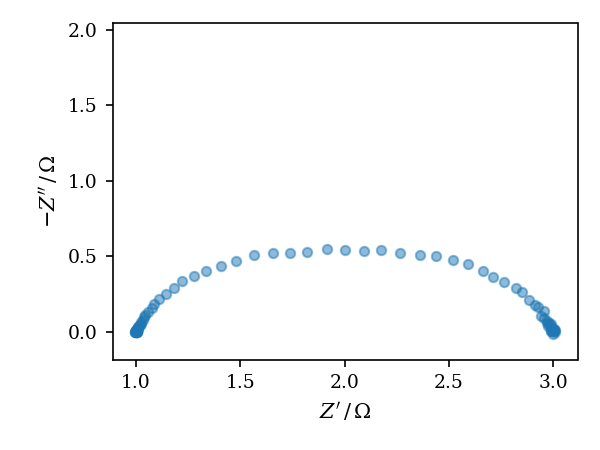

In [178]:
# 2-ZARC nyquist
fig,ax = plt.subplots(figsize=(4,3))

Zfile = 'Z_2ZARC_Orazem_0.25.csv'
Zdf = pd.read_csv(os.path.join(datadir,'simulated',Zfile))

gt.plot_nyquist(Zdf,ax=ax,alpha=0.5,s=20)
fig.tight_layout()

fig.savefig(os.path.join(plotdir,'2ZARC_Nyquist.jpg'),dpi=400)
fig.savefig(os.path.join(presdir,'2ZARC_Nyquist.jpg'),dpi=400)

<IPython.core.display.Javascript object>


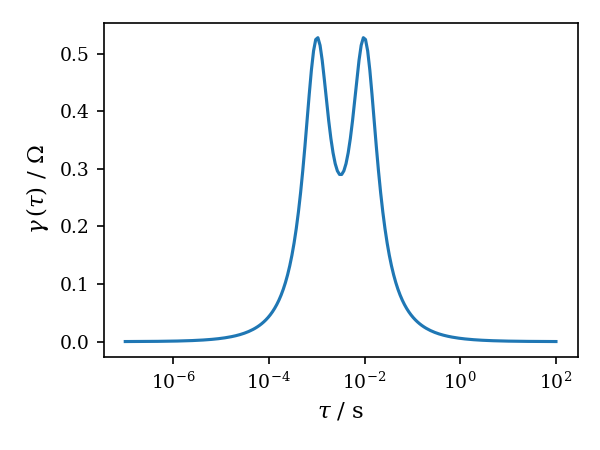

In [28]:
# 2-ZARC DRT
fig,ax = plt.subplots(figsize=(4,3))

gfile = 'gamma_2ZARC.csv'
g_true = pd.read_csv(os.path.join(datadir,'simulated',gfile))
plot_drt(g_true['tau'],g_true['gamma'],ax=ax)

fig.tight_layout()

fig.savefig(os.path.join(plotdir,'2ZARC_DRT.jpg'),dpi=400)
fig.savefig(os.path.join(presdir,'2ZARC_DRT.jpg'),dpi=400)

<IPython.core.display.Javascript object>


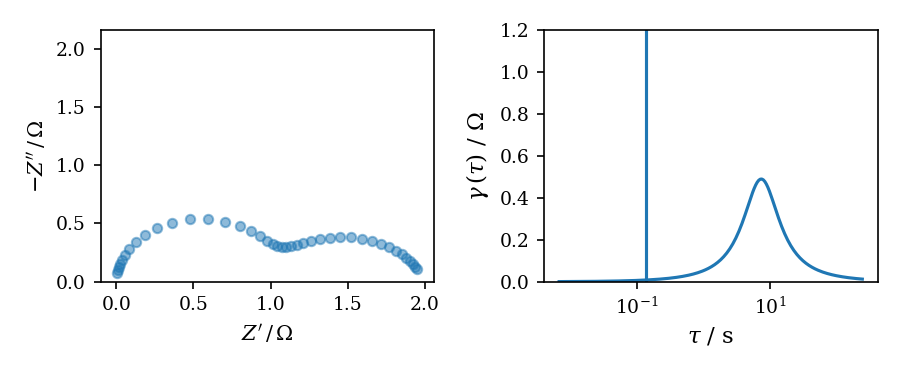

In [180]:
# nyquist and DRT for RC-ZARC
fig,axes = plt.subplots(1,2,figsize=(6,2.5))

# load data
Zfile = 'Z_RC-ZARC_noiseless.csv'
Zdf = pd.read_csv(os.path.join(datadir,'simulated',Zfile))

gfile = 'gamma_RC-ZARC.csv'
g_true = pd.read_csv(os.path.join(datadir,'simulated',gfile))

# plot nyquist
gt.plot_nyquist(Zdf,ax=axes[0],alpha=0.5,s=20)

# plot DRT
plot_drt(g_true['tau'],g_true['gamma'],ax=axes[1])
axes[1].set_ylim(0,1.2)
axes[1].axvline(np.exp(-2))

fig.tight_layout()
fig.savefig(os.path.join(plotdir,'RC-ZARC_NyquistDRT.jpg'),dpi=400)
# fig.savefig(os.path.join(presdir,'2ZARC_DRT.jpg'),dpi=400)

<IPython.core.display.Javascript object>


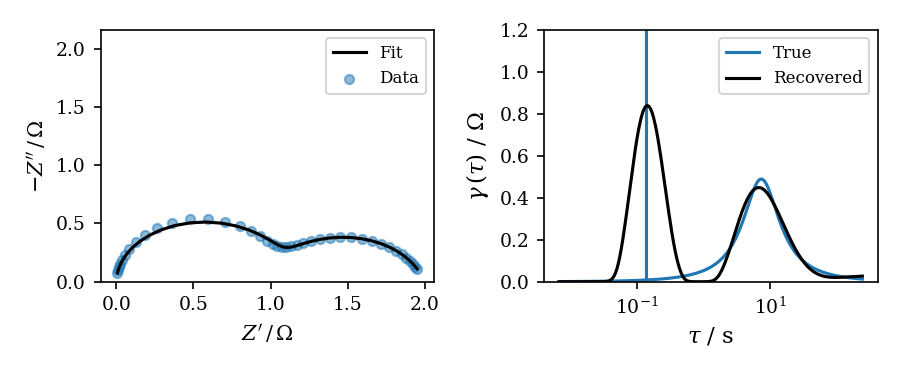

../bayes-drt\drt.py:1095: RuntimeWarning: overflow encountered in exp
  return phi(y,epsilon)/(1+np.exp(2*(y+np.log(w_n*t_m))))


In [181]:
# RC-ZARC with poor (ridge) fit
fig,axes = plt.subplots(1,2,figsize=(6,2.5))

# load data
Zfile = 'Z_RC-ZARC_noiseless.csv'
Zdf = pd.read_csv(os.path.join(datadir,'simulated',Zfile))
freq = Zdf['Freq'].values
Zc = (Zdf['Zreal'] + 1j*Zdf['Zimag']).values

gfile = 'gamma_RC-ZARC.csv'
g_true = pd.read_csv(os.path.join(datadir,'simulated',gfile))

# plot nyquist
gt.plot_nyquist(Zdf,ax=axes[0],alpha=0.5,s=20,label='Data')

# plot true drt
plot_drt(g_true['tau'],g_true['gamma'],ax=axes[1],label='True')
axes[1].set_ylim(0,1.2)
axes[1].axvline(np.exp(-2))

# fit data
basis_tau = np.logspace(-2,3,51)
dr = drt.DRT(basis_freq=1/(2*np.pi*basis_tau))
dr.ridge_fit(freq,Zc,hyper_lambda=False,dZ=False,reg_ord=2,lambda_0=1e-3,nonneg=True)

# plot fit
Z_pred = dr.predict(freq)
df_pred = gt.construct_eis_df(freq,Z_pred)
gt.plot_nyquist(df_pred,plot_func='plot',c='k',label='Fit',ax=axes[0])
axes[1].plot(g_true['tau'],dr.drt(g_true['tau']),c='k',label='Recovered')
axes[1].legend()


fig.tight_layout()
fig.savefig(os.path.join(plotdir,'RC-ZARC_NyquistDRT_RidgeFit.jpg'),dpi=400)

<IPython.core.display.Javascript object>


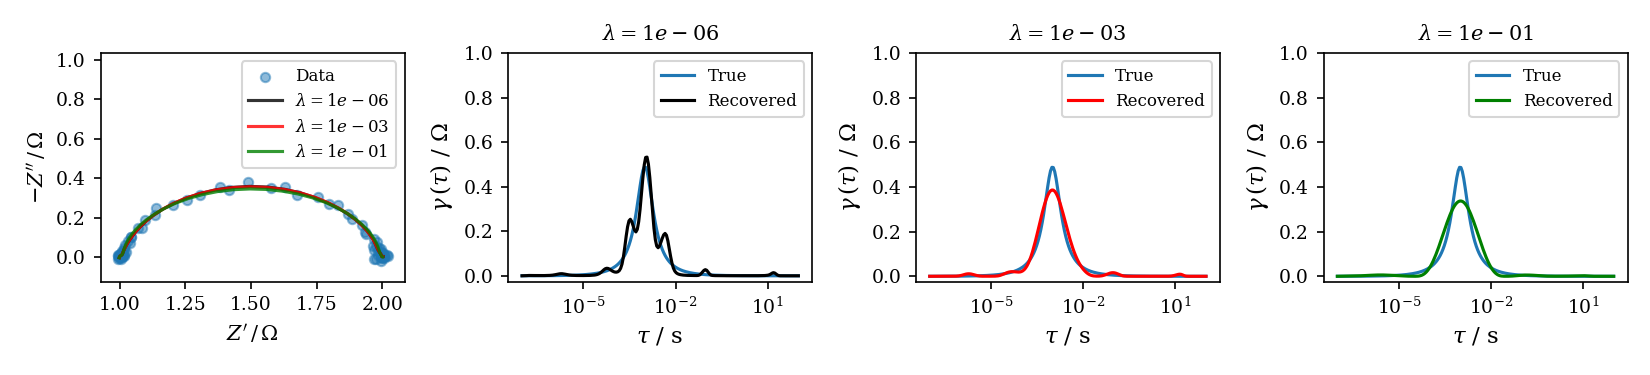

In [194]:
# sensitivity to complexity parameter

fig,axes = plt.subplots(1,4,figsize=(11,2.5))

# load data
Zfile = 'Z_ZARC_Orazem_1.0.csv'
Zdf = pd.read_csv(os.path.join(datadir,'simulated',Zfile))
freq = Zdf['Freq'].values
Zc = (Zdf['Zreal'] + 1j*Zdf['Zimag']).values
gfile = 'gamma_ZARC.csv'
g_true = pd.read_csv(os.path.join(datadir,'simulated',gfile))

gt.plot_nyquist(Zdf,ax=axes[0],alpha=0.5,s=20,label='Data')
fig.tight_layout()

# dr = drt.DRT()

lambdas = [1e-6,1e-3,1e-1]
colors = ['k','r','g']
for ax,lam,c in zip(axes[1:],lambdas,colors):
    # fit
    dr.ridge_fit(freq,Zc,hyper_lambda=False,lambda_0=lam,nonneg=True,dZ=False)
    # plot DRT
    plot_drt(g_true['tau'],g_true['gamma'],label='True',ax=ax)
    ax.plot(g_true['tau'],dr.drt(g_true['tau']),label='Recovered',c=c)
    ax.legend()
    ax.set_title('$\lambda={:.0e}$'.format(lam),size=label_size-1)
    ax.set_ylim(ax.get_ylim()[0],1)
    # plot Z fit
    df_pred = gt.construct_eis_df(freq,dr.predict(freq))
    gt.plot_nyquist(df_pred,ax=axes[0],label='$\lambda={:.0e}$'.format(lam),plot_func='plot',c=c,alpha=0.8)
    
# reorder Nyquist labels
h,l = axes[0].get_legend_handles_labels()
srt_idx = [3,0,1,2]
axes[0].legend(handles=[h[i] for i in srt_idx],labels=[l[i] for i in srt_idx])

fig.tight_layout()    
fig.savefig(os.path.join(plotdir,'ZARC_LambdaSensitivity.jpg'),dpi=400)

<IPython.core.display.Javascript object>


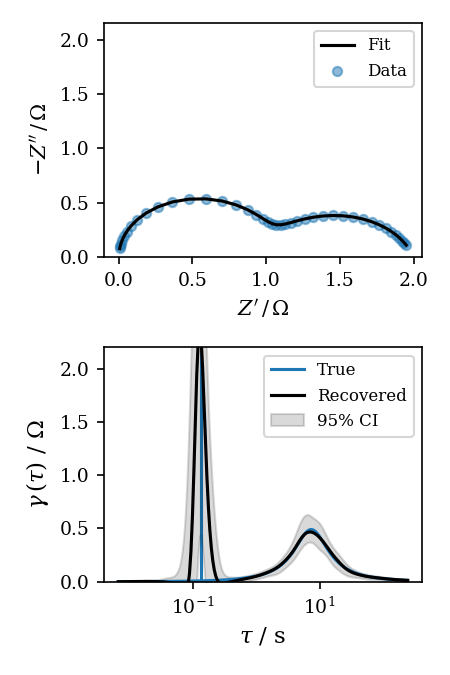

In [183]:
fig,axes = plt.subplots(2,1,figsize=(3,4.5))

# load data
Zfile = 'Z_RC-ZARC_noiseless.csv'
Zdf = pd.read_csv(os.path.join(datadir,'simulated',Zfile))
freq = Zdf['Freq'].values
Zc = (Zdf['Zreal'] + 1j*Zdf['Zimag']).values

gfile = 'gamma_RC-ZARC.csv'
g_true = pd.read_csv(os.path.join(datadir,'simulated',gfile))

# plot nyquist
gt.plot_nyquist(Zdf,ax=axes[0],alpha=0.5,s=20,label='Data')

# plot true drt
plot_drt(g_true['tau'],g_true['gamma'],ax=axes[1],label='True')

# fit data
# basis_tau = np.logspace(-2,3,51)
# dr = drt.DRT(basis_freq=1/(2*np.pi*basis_tau))
# dr.bayes_fit(freq,Zc)

# load fit results
Zres = pd.read_csv('../code_EchemActa/map_results/Zout_RC-ZARC_noiseless.csv')
Gres =  pd.read_csv('../code_EchemActa/bayes_results/Gout_RC-ZARC_noiseless.csv')

# plot fit
gt.plot_nyquist(Zres,plot_func='plot',c='k',label='Fit',ax=axes[0])
axes[1].plot(Gres['tau'],Gres['gamma'],c='k',label='Recovered')
axes[1].fill_between(Gres['tau'],Gres['gamma_lo'],Gres['gamma_hi'],color='k',alpha=0.15,label='95% CI')


axes[1].legend()
axes[1].set_ylim(0,2.2)

ymin = np.interp(np.exp(-2),g_true['tau'],g_true['gamma'])
axes[1].axvline(np.exp(-2),ymin=axes[1].transLimits.transform((1,ymin))[1],zorder=-10)


fig.tight_layout()
fig.savefig(os.path.join(plotdir,'RC-ZARC_NyquistDRT_BayesFit.jpg'),dpi=400)

In [225]:
g_true['tau']

0       0.006738
1       0.007454
2       0.008246
3       0.009123
4       0.010093
         ...    
95     99.083170
96    109.614504
97    121.265190
98    134.154202
99    148.413159
Name: tau, Length: 100, dtype: float64

<IPython.core.display.Javascript object>


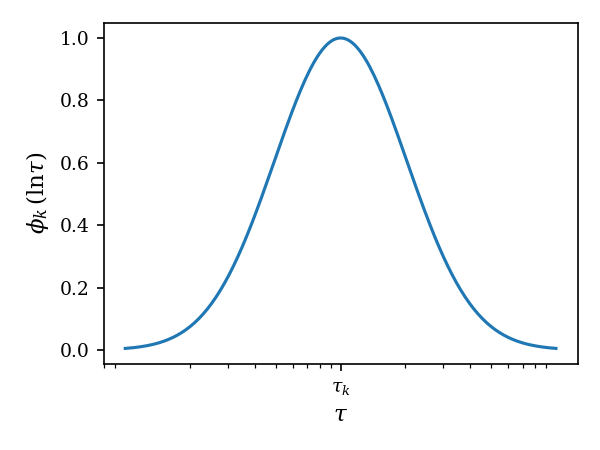

<IPython.core.display.Javascript object>


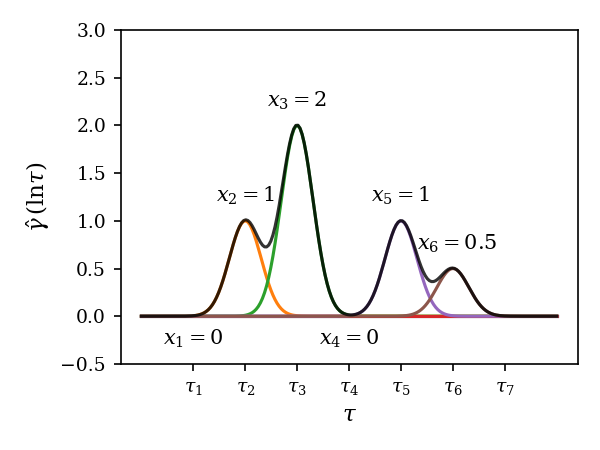

In [174]:
# radial basis function illustration

# single RBF
fig,ax = plt.subplots(figsize=(4,3))

phi = drt.get_basis_func('gaussian')
tau = np.logspace(-1,1,200)
tm = 1

eps = 1
ax.plot(tau,phi(np.log(tau/tm),eps))
ax.set_xscale('log')

ax.set_ylabel(r'$\phi_k \, (\ln{\tau})$')
ax.set_xticks([1])
ax.set_xticklabels([r'$\tau_k$'])
ax.set_xlabel(r'$\tau$')

fig.tight_layout()

# function approx from multiple RBFs

fig2,ax2 = plt.subplots(figsize=(4,3))

tau_basis = np.logspace(-3,3,7)
tau_plot = np.logspace(-4,4,200)
x_vec = np.array([0,1,2,0,1,0.5])
rbfs = [x*phi(np.log(tm/tau_plot),eps) for tm,x in zip(tau_basis,x_vec)]

for k,rbf in enumerate(rbfs):
    # plot individual RBFS
    ax2.plot(tau_plot,rbf,ls='-')
    tau_k = tau_basis[k]
    x_k = x_vec[k]
    y_k = np.max(rbf)
    if y_k==0:
        y_k = -0.3
    else:
        y_k = y_k + 0.2
        
    # shift 6th label slightly right    
    if k==5:
        tau_k *= 1.2
    ax2.text(tau_k,y_k,'$x_{}={:.1g}$'.format(k+1,x_k),ha='center')
    

# plot RBF sum
rbf_sum = np.sum(rbfs,axis=0)
ax2.plot(tau_plot,rbf_sum,c='k',alpha=0.8,ls='-')

ax2.set_xscale('log')
ax2.set_ylim(-0.5,3.)
ax2.set_xticks(tau_basis)
ax2.set_xticklabels([rf'$\tau_{k}$' for k in range(1,1+len(tau_basis))])
ax2.set_xlabel(r'$\tau$')
ax2.set_ylabel(r'$\hat{\gamma} \, (\ln{\tau})$')

fig2.tight_layout()

fig.savefig(os.path.join(plotdir,'SingleRBF.jpg'),dpi=400)
fig2.savefig(os.path.join(plotdir,'RBF_sum.jpg'),dpi=400)

<IPython.core.display.Javascript object>


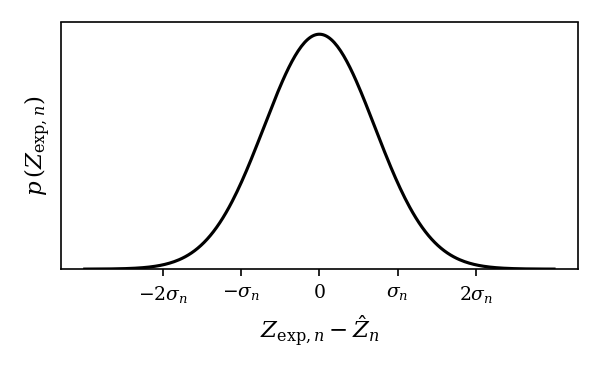

In [195]:
fig,ax = plt.subplots(figsize=(4,2.5))

x = np.linspace(-3,3,300)
sigma = 1
def pdf_normal(x,mu,sigma):
    return (1/(np.sqrt(2*np.pi)*sigma))*np.exp(-((x-mu)/sigma)**2)
ax.plot(x,pdf_normal(x,0,sigma),c='k')
# xi = np.linspace(-1,1,100)
# ax.fill_between(xi,0,pdf_normal(xi,0,sigma),alpha=0.25,lw=0)
# xl = np.linspace(-2,-1,50)
# p1 = ax.fill_between(xl,0,pdf_normal(xl,0,sigma),alpha=0.25,lw=0,color='yellow')
# xh = np.linspace(1,2,50)
# ax.fill_between(xh,0,pdf_normal(xh,0,sigma),alpha=0.25,lw=0,color=p1.get_fc())

# xvl = np.linspace(-3,-2,50)
# xvh = np.linspace(2,3,50)
# for xv in [xvl,xvh]:
#     ax.fill_between(xv,0,pdf_normal(xv,0,sigma),alpha=0.25,lw=0,color='r')


ax.set_xticks([-2,-1,0,1,2])
ax.set_xticklabels([r'$-2\sigma_n$',
                    r'$-\sigma_n$',
                    0,
                    r'$\sigma_n$',
                    r'$2\sigma_n$'])

ax.set_ylim(0,ax.get_ylim()[1])

ax.set_yticks([])
ax.set_xlabel('$Z_{\mathrm{exp},n} - \hat{Z}_n$')
ax.set_ylabel('$p \, (Z_{\mathrm{exp},n})$')
fig.tight_layout()
fig.savefig(os.path.join(plotdir,'Zexp_prior.jpg'),dpi=400)

<IPython.core.display.Javascript object>


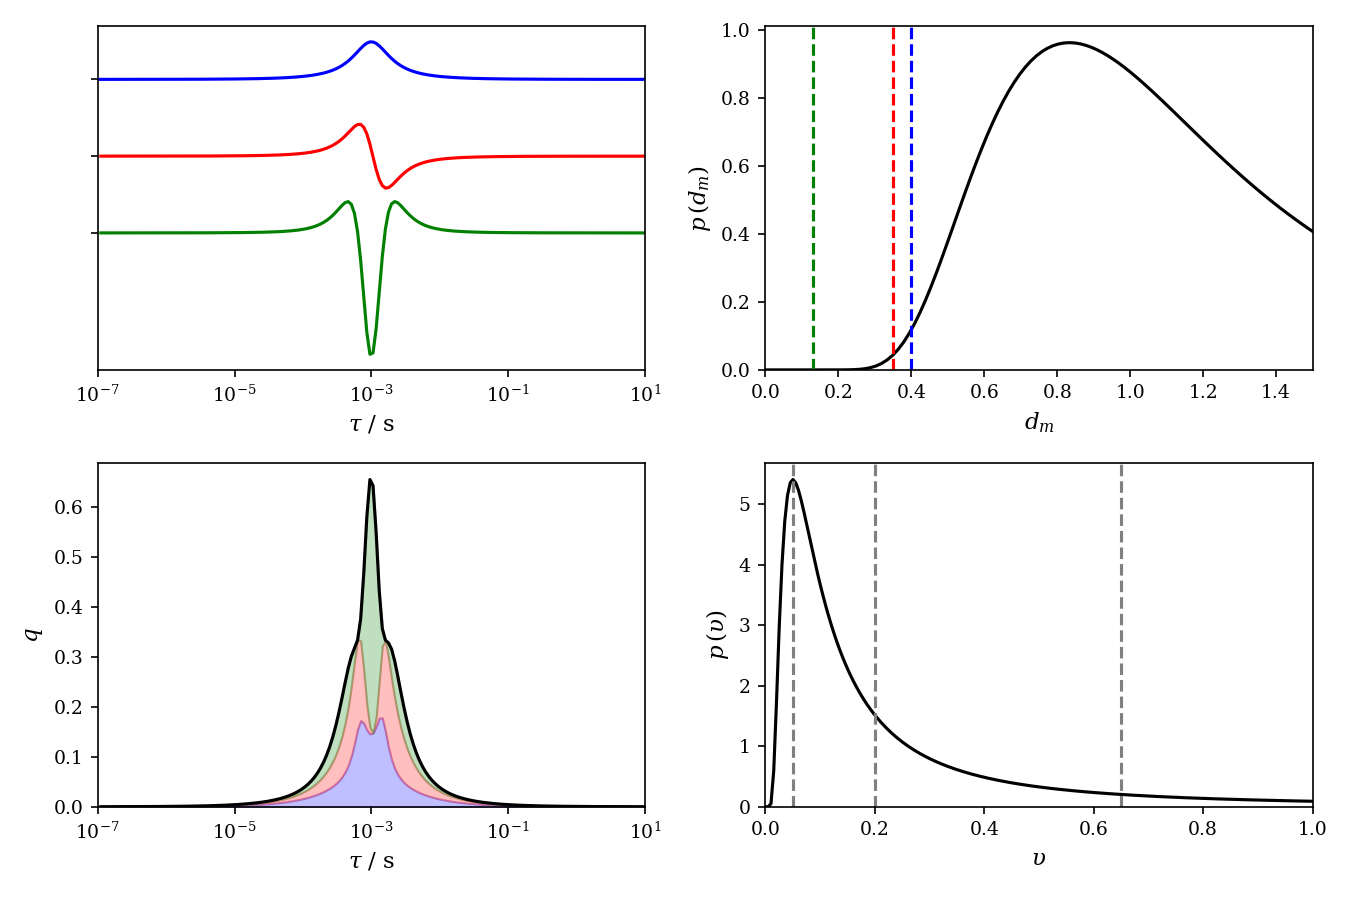

In [150]:
fig,axes = plt.subplots(2,2,figsize=(9,6),sharex=False)

gfile = 'gamma_ZARC.csv'
g_true = pd.read_csv(os.path.join(datadir,'simulated',gfile))
dlnt = np.mean(np.diff(np.log(g_true['tau'])))
p1_offset = np.diff(g_true['gamma'])
tau_d1 = g_true['tau'][:-1]*np.exp(dlnt)
p1 = np.array([np.interp(t,tau_d1,p1_offset) for t in g_true['tau'][1:-1]])
p2 = np.diff(p1_offset)
p0 = g_true['gamma'].values[1:-1]

# plot 0th-2nd derivatives
plot_drt(g_true['tau'],g_true['gamma']+2,ax=axes[0,0],label='$\gamma$',c='b')
axes[0,0].plot(g_true['tau'][1:-1],p1/dlnt + 1,label=r'$\dfrac{\partial \gamma}{\partial \ln{\tau}}$',c='r')
axes[0,0].plot(g_true['tau'][1:-1],p2/dlnt**2,label=r'$\dfrac{\partial^2 \gamma}{\partial \ln{\tau}^2}$',c='g')
# axes[0].legend(loc='lower right',fontsize=10)
axes[0,0].set_ylabel('')
axes[0,0].set_yticks([0,1,2])
# h,l = axes[0,0].get_legend_handles_labels()
axes[0,0].set_yticklabels([])#l[::-1])

# plot inverse gamma prior for d_m
def pdf_invgamma(x,shape,rate):
    return rate**shape*x**(-shape-1)*np.exp(-rate/x)/(gamma(shape))

d0 = 0.4
d1 = 0.35
d2 = 0.13

x = np.linspace(1e-4,1.5,100)
axes[0,1].plot(x,pdf_invgamma(x,5,5),c='k')
axes[0,1].axvline(d0,ls='--',c='b')
axes[0,1].axvline(d1,ls='--',c='r')
axes[0,1].axvline(d2,ls='--',c='g')
axes[0,1].set_xlabel('$d_m$')
axes[0,1].set_ylabel('$p \, (d_m)$')

axes[0,1].set_xlim(0,1.5)
axes[0,1].set_ylim(0,axes[0,1].get_ylim()[1])

# plot weighted sum
ptot = (d0*p0**2 + d1*(p1/dlnt)**2 + d2*(p2/dlnt**2)**2)**0.5
f0 = d0*p0**2/ptot**2
f1 = d1*(p1/dlnt)**2/ptot**2
f2 = d2*(p2/dlnt**2)**2/ptot**2

axes[1,0].fill_between(g_true['tau'][1:-1],0,f0*ptot,color='b',alpha=0.25)
axes[1,0].fill_between(g_true['tau'][1:-1],f0*ptot,(f0+f1)*ptot,color='r',alpha=0.25)
axes[1,0].fill_between(g_true['tau'][1:-1],(f0+f1)*ptot,ptot,color='g',alpha=0.25)
# axes[1,0].fill_between(g_true['tau'][1:-1],d0*p0+np.abs(d1*p1/dlnt),d0*p0+np.abs(d1*p1/dlnt) + np.abs(d2*p2/dlnt**2),color='g',alpha=0.25)
# axes[1,0].fill_between(g_true['tau'][1:-1],d0*p0,(d0*p0**2 + d1*(p1/dlnt)**2)**0.5,color='r',alpha=0.25)
# axes[1,0].plot(g_true['tau'][1:-1],np.abs(d2*p2/dlnt**2))
axes[1,0].plot(g_true['tau'][1:-1],ptot,c='k')
axes[1,0].set_ylabel('$q$')
axes[1,0].set_xscale('log')
axes[1,0].set_xlabel(r'$\tau$ / s')
axes[1,0].set_ylim(0,axes[1,0].get_ylim()[1])

# plot distribution local scale
x2 = np.linspace(1e-4,1,200)
axes[1,1].plot(x2,pdf_invgamma(x2,1,0.1),c='k')
axes[1,1].set_xlabel(r'$\upsilon$')
axes[1,1].set_ylabel(r'$p \, (\upsilon)$')
axes[1,1].axvline(0.65,ls='--',c='gray')
axes[1,1].axvline(0.2,ls='--',c='gray')
axes[1,1].axvline(0.05,ls='--',c='gray')
axes[1,1].set_xlim(0,1)
axes[1,1].set_ylim(0,axes[1,1].get_ylim()[1])

for ax in axes[:,0]:
    ax.set_xlim(1e-7,1e1)

# for ax in axes.ravel():
#     ax.set_xlabel(r'$\tau$')

fig.tight_layout()
fig.savefig(os.path.join(plotdir,'ComplexityPriors.jpg'),dpi=400)

<IPython.core.display.Javascript object>


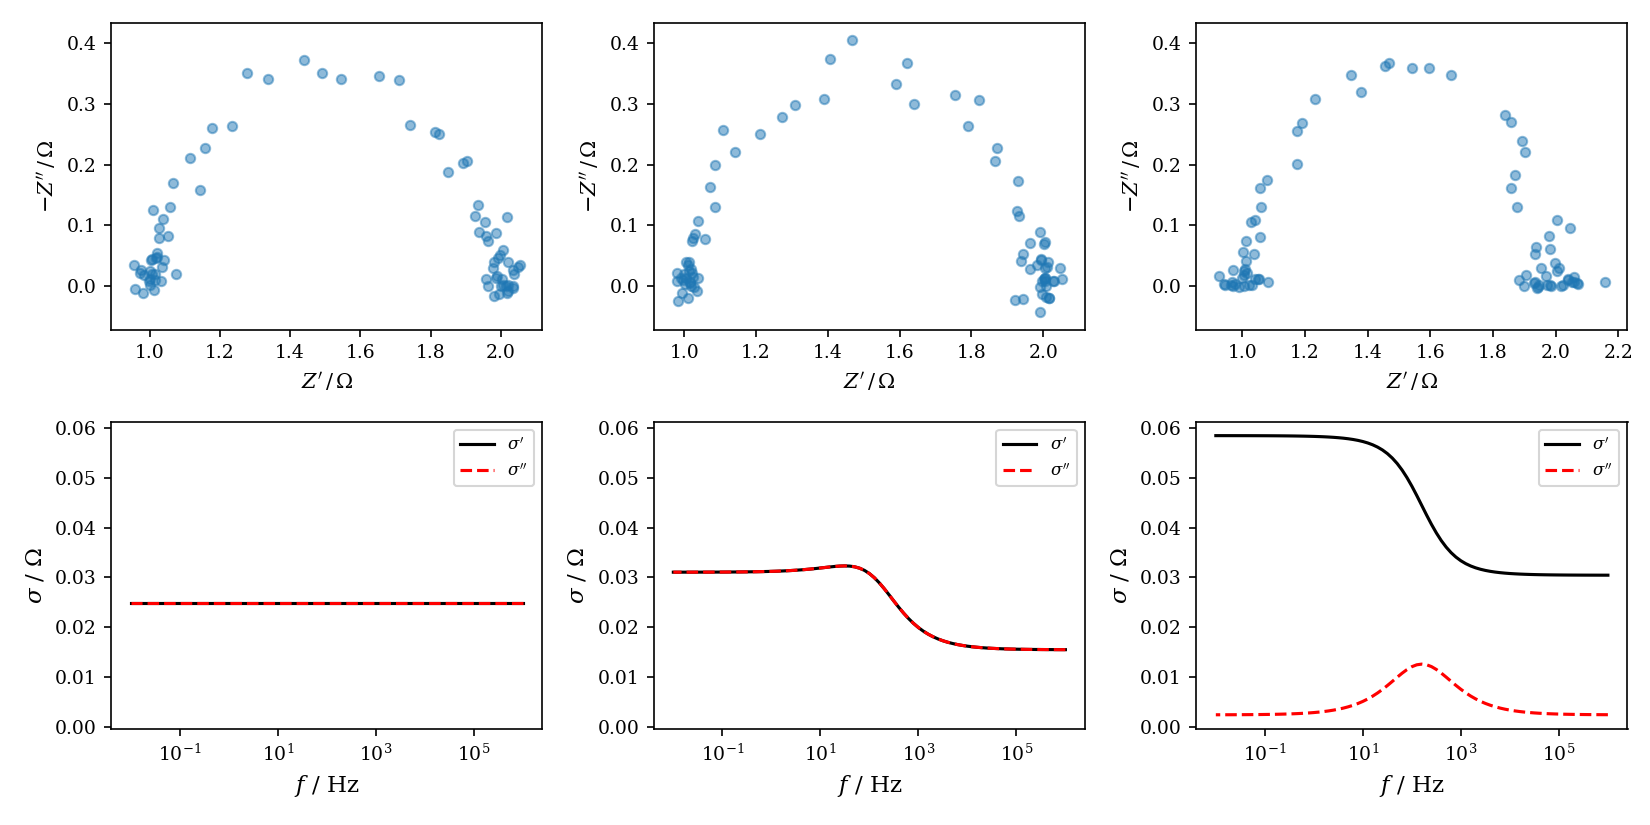

In [71]:
# error structures

fig,axes = plt.subplots(2,3,figsize=(11,5.5))

circ = 'ZARC'
err_models = ['uniform','Orazem','Macdonald']

axes[0,0].get_shared_y_axes().join(axes[0,0],axes[0,1],axes[0,2])
axes[1,0].get_shared_y_axes().join(axes[1,0],axes[1,1],axes[1,2])

for axcol,err_model in zip(axes.T,err_models):
    Zdf = pd.read_csv(os.path.join(datadir,'simulated',f'Z_{circ}_{err_model}_2.5.csv'))
    
    gt.plot_nyquist(Zdf,ax=axcol[0],alpha=0.5,s=20,eq_xy=True)
    
    axcol[1].plot(Zdf['Freq'],Zdf['sigma_re'],label='$\sigma^\prime$',c='k')
    axcol[1].plot(Zdf['Freq'],Zdf['sigma_im'],label='$\sigma^{\prime\prime}$',ls='--',c='r')
    axcol[1].set_xscale('log')
    axcol[1].legend()
    axcol[1].set_xlabel('$f$ / Hz')
    axcol[1].set_ylabel('$\sigma \ / \ \Omega$')
    
fig.tight_layout()
# fig.savefig(os.path.join(plotdir,'ZARC_ErrModels.jpg'),dpi=400)

<IPython.core.display.Javascript object>


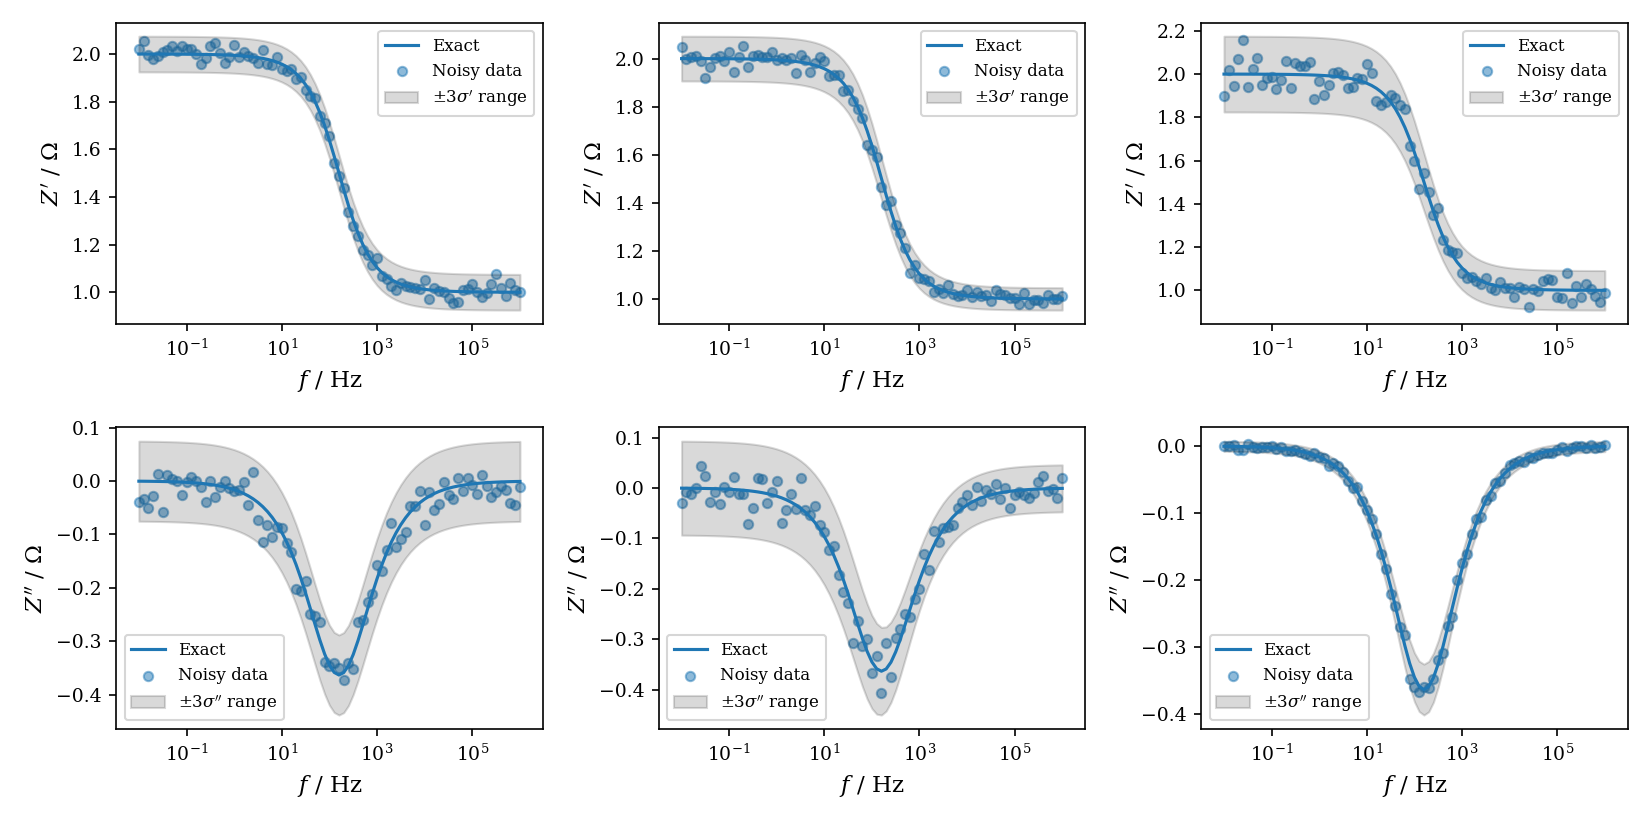

In [280]:
# error structures

fig,axes = plt.subplots(2,3,figsize=(11,5.5))

circ = 'ZARC'
err_models = ['uniform','Orazem','Macdonald']

# axes[0,0].get_shared_y_axes().join(axes[0,0],axes[0,1],axes[0,2])
# axes[1,0].get_shared_y_axes().join(axes[1,0],axes[1,1],axes[1,2])

for axcol,err_model in zip(axes.T,err_models):
    Zdf = pd.read_csv(os.path.join(datadir,'simulated',f'Z_{circ}_noiseless.csv'))
    Zndf = pd.read_csv(os.path.join(datadir,'simulated',f'Z_{circ}_{err_model}_2.5.csv'))
    
    gt.plot_bode(Zdf,axes=axcol,plot_func='plot',label='Exact',cols=['Zreal','Zimag'])
    gt.plot_bode(Zndf,axes=axcol,alpha=0.5,s=20,label='Noisy data',cols=['Zreal','Zimag'])
    
    axcol[0].fill_between(Zndf['Freq'],Zdf['Zreal'] - 3*Zndf['sigma_re'],Zdf['Zreal'] + 3*Zndf['sigma_re'],
                          color='k',alpha=0.15,label='$\pm 3\sigma^\prime$ range')
    axcol[1].fill_between(Zndf['Freq'],Zdf['Zimag'] - 3*Zndf['sigma_im'],Zdf['Zimag'] + 3*Zndf['sigma_im'],
                          color='k',alpha=0.15,label='$\pm 3\sigma^{\prime\prime}$ range')
    
#     axcol[1].plot(Zdf['Freq'],Zdf['sigma_im'],label='$\sigma^{\prime\prime}$',ls='--',c='r')
    
#     axcol[1].set_xscale('log')
    axcol[0].legend()
    axcol[1].legend()
#     axcol[1].set_xlabel('$f$ / Hz')
#     axcol[1].set_ylabel('$\sigma \ / \ \Omega$')
    
fig.tight_layout()
fig.savefig(os.path.join(plotdir,'ZARC_ErrModels.jpg'),dpi=400)

# Results

In [184]:
en_path = '../code_EchemActa/comparisons/ElasticNet/results'
gp_path = '../code_EchemActa/comparisons/GP-DRT/results/for_figs'

model_info = {'PM':{'path':'../code_EchemActa/bayes_results','color':'k'},
              'MAP':{'path':'../code_EchemActa/map_results','color':'r'},
              'EN':{'path':en_path,'color':'purple'},
              'GP':{'path':gp_path,'color':'g'},
             }

def load_Zres(file,model):
    "Load Z result file and parse if necessary"
    Zres = pd.read_csv(file)
    if model=='PM':
        # parse complex numbers
        real_cols = ['freq','Zreal','Zimag']
        for col in real_cols:
            Zres[col] = Zres[col].str.replace('i','j').apply(lambda x: np.complex(x))
            Zres[col] = np.real(Zres[col])
        complex_cols = ['Zlo','Zhi']
        for col in complex_cols:
            Zres[col] = Zres[col].str.replace('i','j').apply(lambda x: np.complex(x))   
    return Zres

def plot_model_drt(Gres,model_name,ax,color):
    "Plot recovered DRT with CIs if appropriate"
    if model_name=='PM':
        ax.plot(Gres['tau'],Gres['gamma'],label='PM',c=color)
        ax.fill_between(Gres['tau'],Gres['gamma_lo'],Gres['gamma_hi'],alpha=0.15,label='95% CI',
                               color=color,lw=1)
    elif model_name=='MAP':
        ax.plot(Gres['tau'],Gres['gamma'],label='MAP',c=color,ls='-',alpha=1)
    elif model_name=='GP':
        ax.plot(Gres['tau'],Gres['gamma'],c=color,label='GP')
        ax.fill_between(Gres['tau'],Gres['gamma']-2*Gres['sigma_gamma'],Gres['gamma']+2*Gres['sigma_gamma'],
                            alpha=0.2,color=color,label='95% CI',lw=1)
    else:
        ax.plot(Gres['tau'],Gres['gamma'],c=color,label=model_name)
        
def plot_true_drt(circ,ax,trunc_tau_plot,Zdf,**kw):
    """plot true DRT. Must come after all other plotting functions and axis adjustments to ensure that 
    hlines and vlines are positioned corrrectly"""
    tmax = 1/(2*np.pi*Zdf['Freq'].min())
    tmin = 1/(2*np.pi*Zdf['Freq'].max())
    if circ=='RC':
        ax.axvline(1e-2,lw=1,ymin=ax.transLimits.transform((1,0))[1],zorder=-10,**kw)
        ax.axhline(0,zorder=-10,label='True',xmin=ax.transLimits.transform((np.log10(tmin),0))[0],
                  xmax=ax.transLimits.transform((np.log10(tmax),0))[0],**kw)
    elif circ=='2RC':
        ax.axvline(1e-2,lw=1,ymin=ax.transLimits.transform((1,0))[1],zorder=-10,**kw)
        ax.axvline(1e-3,lw=1,ymin=ax.transLimits.transform((1,0))[1],zorder=-10,**kw)
        ax.axhline(0,zorder=-10,label='True',xmin=ax.transLimits.transform((np.log10(tmin),0))[0],
                  xmax=ax.transLimits.transform((np.log10(tmax),0))[0],**kw)
    else:
        g_file = os.path.join(datadir,'simulated',f'gamma_{circ}.csv')
        g_true = pd.read_csv(g_file)
        if trunc_tau_plot:
            g_true = g_true[(g_true['tau']>= tmin) & 
                            (g_true['tau']<= tmax)
                           ]
        ax.plot(g_true['tau'],g_true['gamma'],label='True',zorder=-10,**kw)
        
        if circ=='trunc':
            # add RL element and measurement boundaries
            ax.axvline(1e-6,lw=1,ymax=ax.transLimits.transform((1,0))[1],zorder=-10,**kw)
            ax.axvline(tmax,ls=':',c='k',lw=1)
            ax.axvline(tmin,ls=':',c='k',lw=1)
        elif circ=='RC-ZARC':
            # add RC element
            ymin = np.interp(np.exp(-2),g_true['tau'],g_true['gamma'])
            print(ymin)
            ax.axvline(np.exp(-2),ymin=ax.transLimits.transform((1,ymin))[1],zorder=-10,**kw)
            
    ax.set_xscale('log')
    ax.set_xlabel(r'$\tau$ / s')
    ax.set_ylabel(r'$\gamma \, (\tau) \ / \ \Omega$')
    
    
def compare_sim_results(circ,err,trunc_tau_plot,show_true_drt=True):
    fig,axes = plt.subplots(2,4,figsize=(12,5.5))

    # share axes for all DRT plots
    axes[0,0].get_shared_x_axes().join(*axes[0,:])
    axes[0,0].get_shared_y_axes().join(*axes[0,:])

    # load impedance data and true DRT 
    Zfile = os.path.join(datadir,'simulated',f'Z_{circ}_noiseless.csv')
    Znfile = os.path.join(datadir,'simulated',f'Z_{circ}_{err}.csv')

    Zdf = pd.read_csv(Zfile)
    Zndf = pd.read_csv(Znfile)

    # get results filenames
    fname = os.path.split(Znfile)[1]
    suffix = fname[1:]
    Zout = f'Zout{suffix}'
    Gout = f'Gout{suffix}'
    
    # plot the true DRT for all top axes
    if show_true_drt:
        for ax in axes[0]:
            plot_true_drt(circ,ax,trunc_tau_plot,Zdf)

    # plot noisy data for all model plots
    for ax in axes[1]:
        gt.plot_nyquist(Zndf,ax=ax,alpha=0.4,s=20,label='Noisy data',eq_xy=True)
        gt.plot_nyquist(Zdf,ax=ax,plot_func='plot',label='Exact',eq_xy=True)

    # plot model results
    model_ax = {'PM':1,'MAP':1,'GP':2,'EN':3}

    for model,info in model_info.items():
        axcol = axes[:,model_ax[model]]
        path = info['path']
        color = info['color']
        Zres = load_Zres(os.path.join(path,Zout),model)
        Gres = pd.read_csv(os.path.join(path,Gout))
        if trunc_tau_plot:
            # limit DRT range to data range to avoid large CIs on GP
            tmin = 1/(2*np.pi*Zdf['Freq'].max())
            tmax = 1/(2*np.pi*Zdf['Freq'].min())
            Gres = Gres[(Gres['tau']>= tmin) & (Gres['tau']<= tmax)]

        plot_model_drt(Gres,model,axcol[0],color)
        gt.plot_nyquist(Zres,ax=axcol[1],plot_func='plot',c=color,label=model,eq_xy=True)

    for ax in axes[0,1:]:
        ax.legend(loc='upper left')

    fig.tight_layout()
    
    return fig, axes

<IPython.core.display.Javascript object>


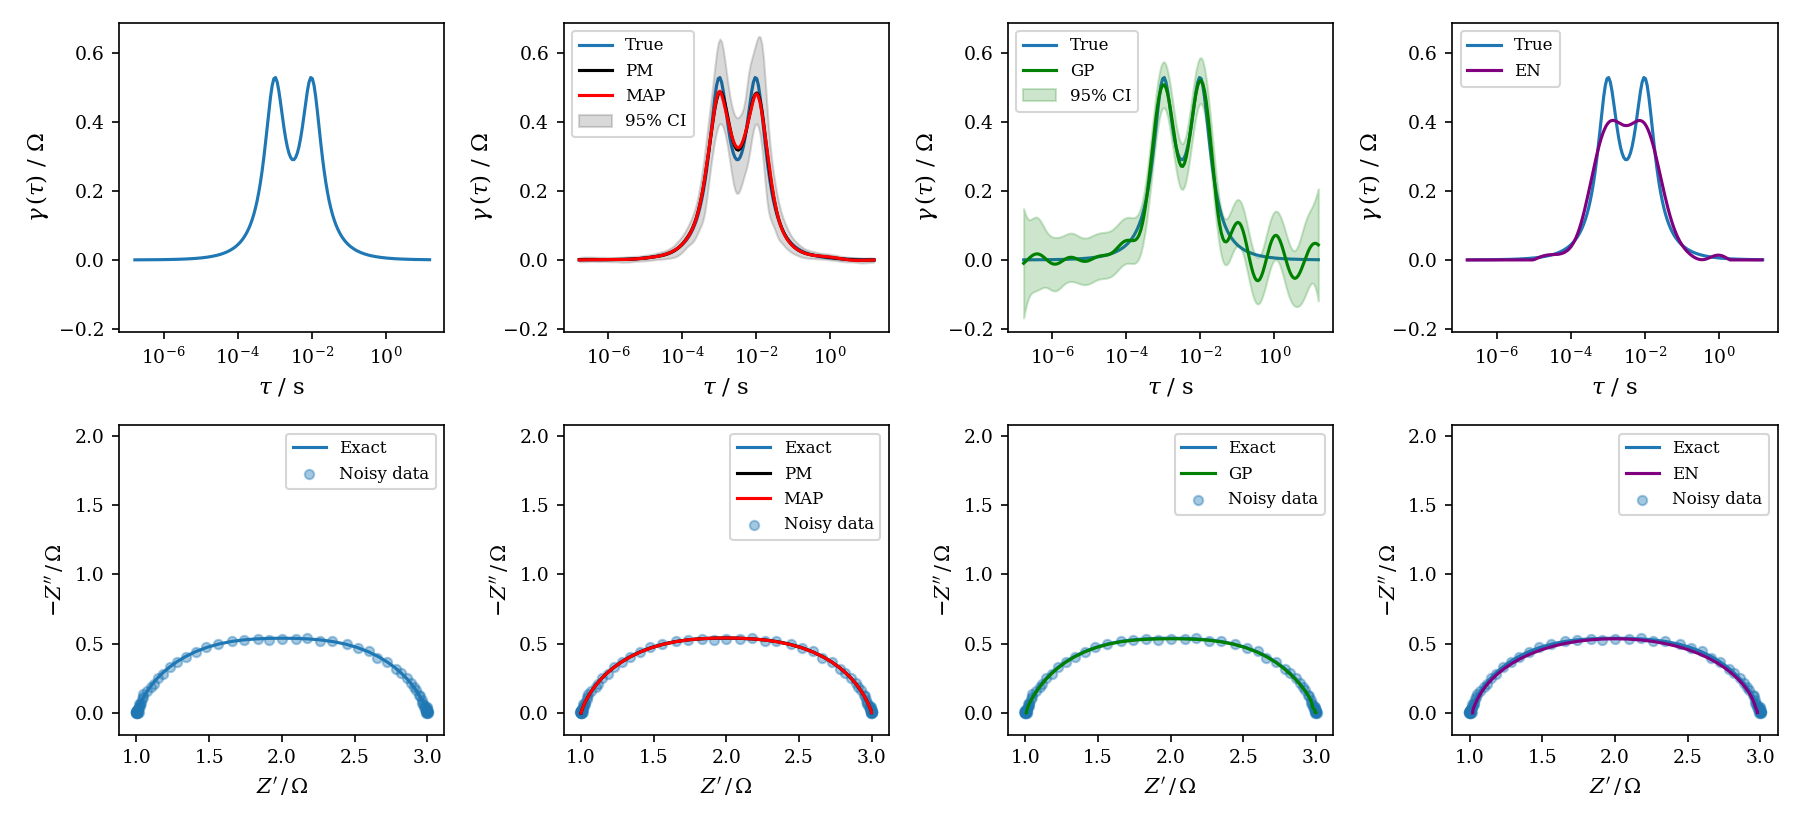

In [185]:
# Overlapping ZARCs
circ = '2ZARC'
err = 'uniform_0.25'
fig,axes = compare_sim_results(circ,err,True)
    
fig.savefig(os.path.join(plotdir,f'DrtCompare_{circ}_{err}.png'),dpi=400,transparent=True)

<IPython.core.display.Javascript object>


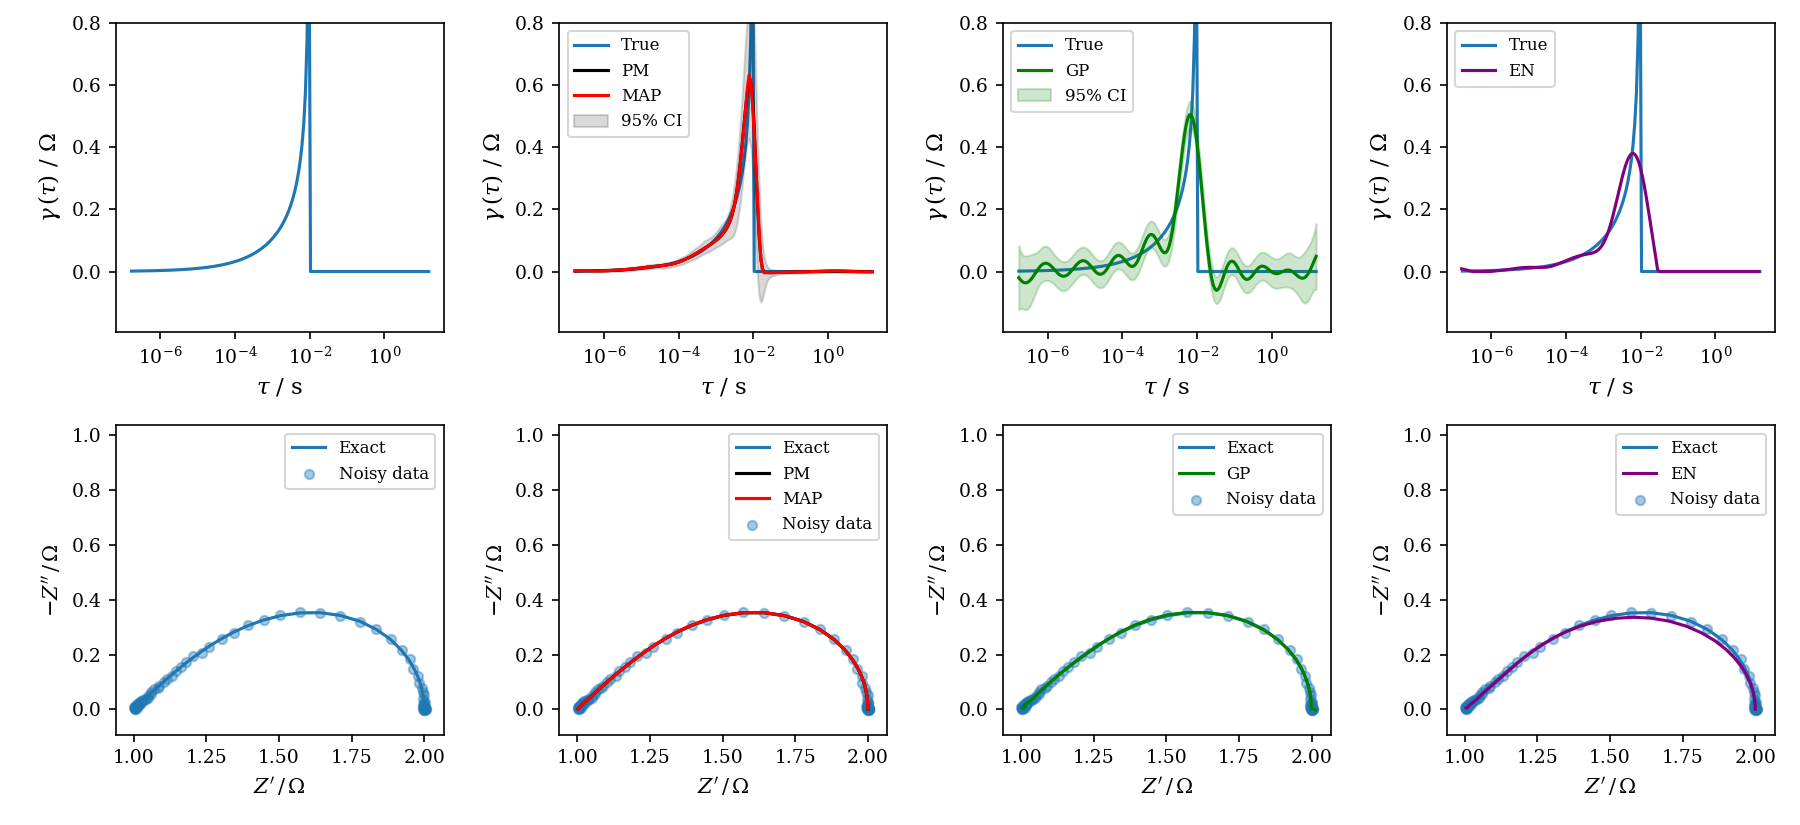

In [186]:
circ = 'Gerischer'
err = 'uniform_0.25'
fig,axes = compare_sim_results(circ,err,True)

axes[0,0].set_ylim(axes[0,0].get_ylim()[0],0.8)
    
fig.savefig(os.path.join(plotdir,f'DrtCompare_{circ}_{err}.png'),dpi=400,transparent=True)

<IPython.core.display.Javascript object>


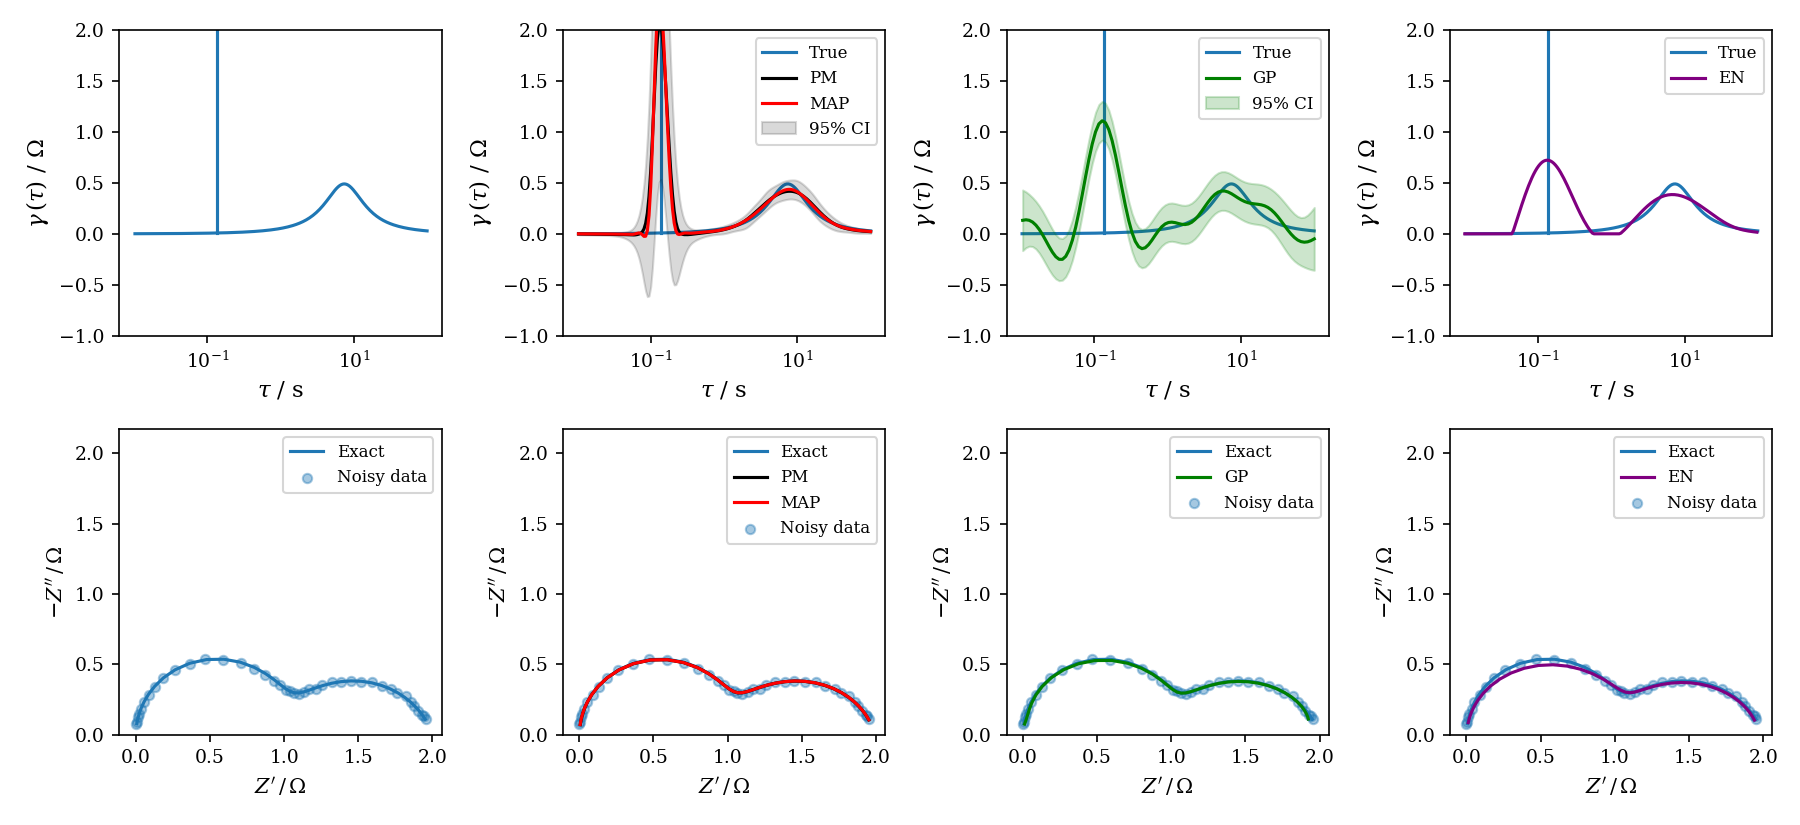

0.008150430615657246
0.008150430615657246
0.008150430615657246
0.008150430615657246


In [80]:
circ = 'RC-ZARC'
err = 'uniform_0.25'
fig,axes = compare_sim_results(circ,err,True,show_true_drt=False)
Zdf = pd.read_csv(os.path.join(datadir,'simulated',f'Z_{circ}_noiseless.csv'))

axes[0,0].set_ylim(-1,2)
for i,ax in enumerate(axes[0]):
    # plot true drt after setting ylim
    plot_true_drt(circ,ax,True,Zdf)
    # reposition and reorder legend
    if i > 0:
        if i==1:
            sort_idx = [2,0,1,3]
        elif i==2:
            sort_idx = [1,0,2]
        elif i==3:
            sort_idx = [1,0]
        h,l = ax.get_legend_handles_labels()
        ax.legend(handles=[h[i] for i in sort_idx],labels=[l[i] for i in sort_idx],loc='upper right')
    
fig.tight_layout()
    
fig.savefig(os.path.join(plotdir,f'DrtCompare_{circ}_{err}.png'),dpi=400,transparent=True)

<IPython.core.display.Javascript object>


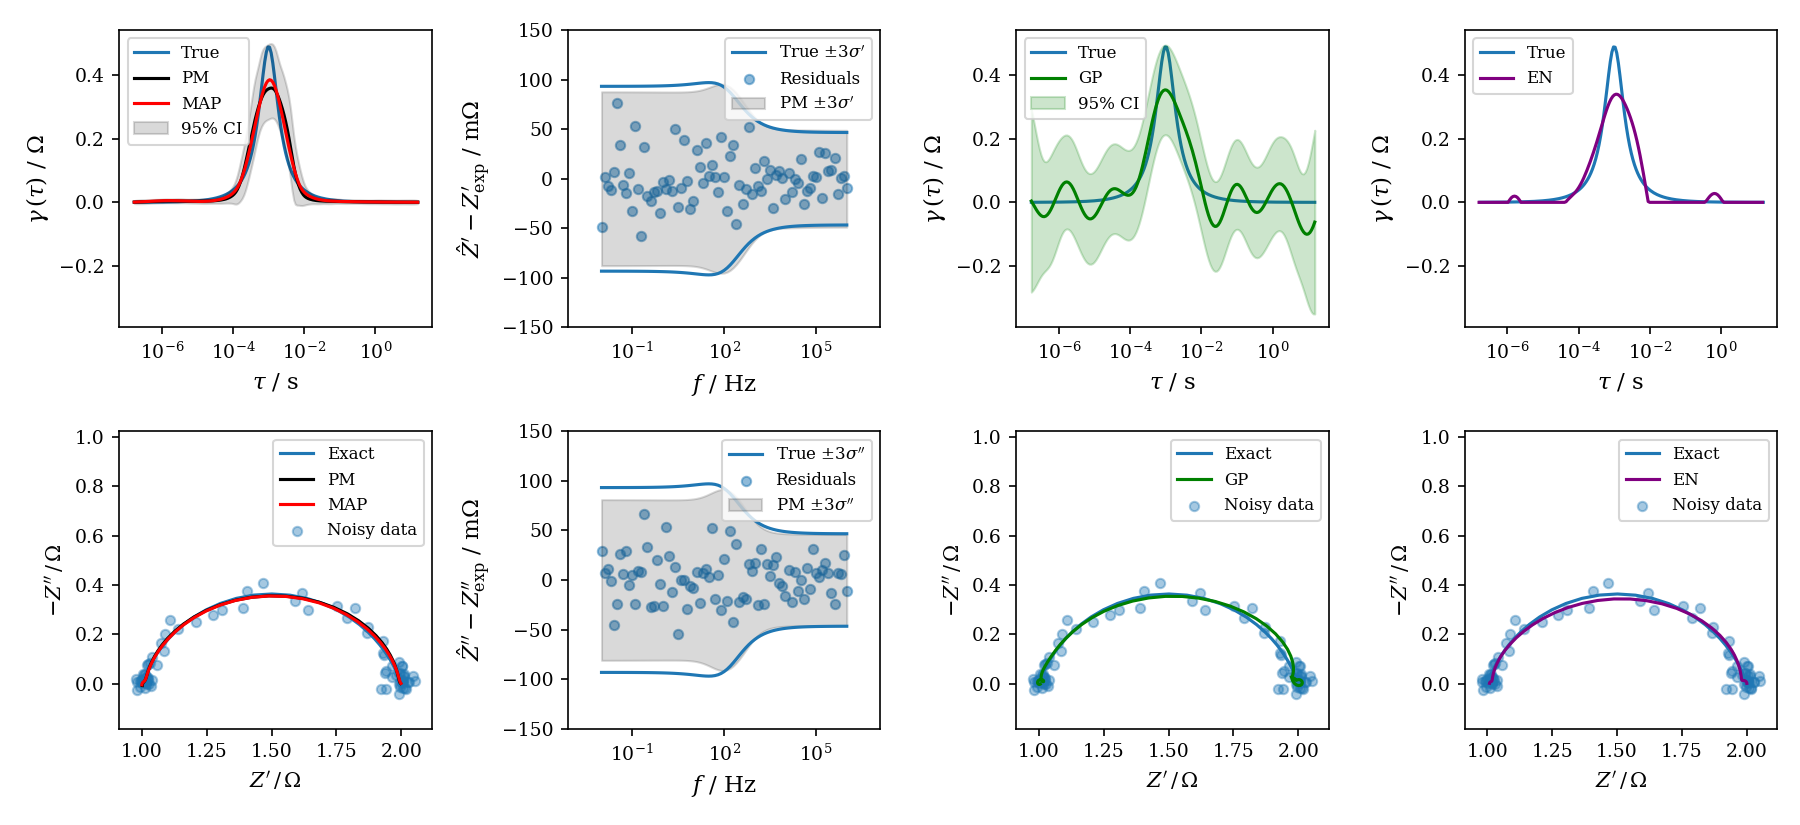

In [81]:
# Noise tolerance and error structure recovery

circ = 'ZARC'
err = 'Orazem_2.5'
trunc_tau_plot=True
show_true_drt=True

fig,axes = plt.subplots(2,4,figsize=(12,5.5))

# share axes for all DRT plots
axes[0,0].get_shared_x_axes().join(axes[0,0],axes[0,2],axes[0,3])
axes[0,0].get_shared_y_axes().join(axes[0,0],axes[0,2],axes[0,3])

# load impedance data and true DRT 
Zfile = os.path.join(datadir,'simulated',f'Z_{circ}_noiseless.csv')
Znfile = os.path.join(datadir,'simulated',f'Z_{circ}_{err}.csv')

Zdf = pd.read_csv(Zfile)
Zndf = pd.read_csv(Znfile)

# get results filenames
fname = os.path.split(Znfile)[1]
suffix = fname[1:]
Zout = f'Zout{suffix}'
Gout = f'Gout{suffix}'
pkl = 'obj{}.pkl'.format(suffix[:-4])

# plot the true DRT for all top axes
if show_true_drt:
    for ax in axes[0,[0,2,3]]:
        plot_true_drt(circ,ax,trunc_tau_plot,Zdf)

# plot noisy data for all model plots
for ax in axes[1,[0,2,3]]:
    gt.plot_nyquist(Zndf,ax=ax,alpha=0.4,s=20,label='Noisy data')
    gt.plot_nyquist(Zdf,ax=ax,plot_func='plot',label='Exact')

# plot model results
model_ax = {'PM':0,'MAP':0,'GP':2,'EN':3}

for model,info in model_info.items():
    axcol = axes[:,model_ax[model]]
    path = info['path']
    color = info['color']
    Zres = load_Zres(os.path.join(path,Zout),model)
    Gres = pd.read_csv(os.path.join(path,Gout))
    if trunc_tau_plot:
        # limit DRT range to data range to avoid large CIs on GP
        tmin = 1/(2*np.pi*Zdf['Freq'].max())
        tmax = 1/(2*np.pi*Zdf['Freq'].min())
        Gres = Gres[(Gres['tau']>= tmin) & (Gres['tau']<= tmax)]

    plot_model_drt(Gres,model,axcol[0],color)
    gt.plot_nyquist(Zres,ax=axcol[1],plot_func='plot',c=color,label=model)
    
    if model in ('PM'):#,'MAP'):
        # plot residuals and recovered structure
        
        # plot residuals
        Zerr = Zndf.copy()
        Zerr['Zreal'] =  Zres['Zreal'] - Zndf['Zreal'] 
        Zerr['Zimag'] =  Zres['Zimag'] - Zndf['Zimag']
        scale_factor = gt.get_scale_factor(Zerr)
        unit_scale = gt.get_unit_scale(Zerr)
        gt.plot_bode(Zerr,axes=axes[:,1],cols=['Zreal','Zimag'],label='Residuals',alpha=0.5,s=20)
        
        # load pickled DRT instance to get recovered error structure
        drl = load_pickle(os.path.join(model_info['PM']['path'],pkl))
        sigma_re,sigma_im = drl.predict_err_scale(Zndf['Freq'].values)
        axes[0,1].fill_between(Zdf['Freq'],-3*sigma_re/scale_factor,3*sigma_re/scale_factor,
                               alpha=0.15,color=color,label='PM $\pm 3 \sigma^\prime$')
        axes[1,1].fill_between(Zdf['Freq'],-3*sigma_im/scale_factor,3*sigma_im/scale_factor,
                               alpha=0.15,color=color,label='PM $\pm 3 \sigma^{\prime\prime}$')
        
        # plot true error structure
        for ax,col,mathlabel in zip(axes[:,1],['sigma_re','sigma_im'],
                               ['$\pm 3 \sigma^{\prime}$','$\pm 3 \sigma^{\prime\prime}$']):
            p = ax.plot(Zdf['Freq'],-3*Zndf[col]/scale_factor,label='True '+mathlabel)
            ax.plot(Zdf['Freq'],3*Zndf[col]/scale_factor,c=p[0].get_color())
        

for ax in axes[:,1]:
    ax.legend(loc='upper right')
    # make room for legend
    ax.set_ylim(-150,150)
    ax.set_xlim(ax.get_xlim()[0]/5,ax.get_xlim()[1]*5)
    
axes[0,1].set_ylabel(f'$\hat{{Z}}^\prime - Z^\prime_{{\mathrm{{exp}}}}$ / {unit_scale}$\Omega$')
axes[1,1].set_ylabel(f'$\hat{{Z}}^{{\prime\prime}} - Z^{{\prime\prime}}_{{\mathrm{{exp}}}}$ / {unit_scale}$\Omega$')

for ax in axes[0,[0,2,3]]:
    ax.legend(loc='upper left')

fig.tight_layout()

fig.savefig(os.path.join(plotdir,'ZARC_ErrorRecovery.png'),dpi=400,transparent=True)

In [45]:
drl = load_pickle(os.path.join(model_info['PM']['path'],pkl))

## Experimental data

In [175]:
def Z_varRQ_ger(w,HFR,Y,t0,**RC_params):
    """
    Impedance of circuit with 1-n parallel RQ circuits in series with a resistor (HFR) and Gerischer element (Y, t0)
    Args:
        w: frequency (Hz)
        HFR: high-frequency resistance
        Y: admittance of Gerischer element
        t0: characteristic time constant of Gerischer element
        RC_params: parameters for each parallel RQ circuit. keys: R, Q, n
    """
    num_RC = int(len(RC_params)/3)

    Z_RC = [gt.Z_par(gt.Z_cpe(w,RC_params[f'Q{i}'],RC_params[f'n{i}']), RC_params[f'R{i}']) for i in range(num_RC)]

    return gt.Z_ger(w,Y,t0) + HFR + np.sum(Z_RC,axis=0)

def plot_exp_results(Z_file,Zecm_file,g_file,suffix,extrap_freq=None):
    fig,axes = plt.subplots(2,4,figsize=(12.5,5.5))

    if Z_file.find('DRTtools') > 0:
        Zdf = pd.read_csv(Z_file,sep='\t',header=None)
        Zdf = pd.DataFrame(Zdf.values,columns=['Freq','Zreal','Zimag'])
    else:
        Zdf = gt.read_eis_zdata(Z_file)
    freq = Zdf['Freq'].values
    scale_factor = gt.get_scale_factor(Zdf)
    unit_scale = gt.get_unit_scale(Zdf)

    # share axes for Nyquist plots
    axes[0,0].get_shared_x_axes().join(axes[0,0],axes[0,2])
    axes[0,0].get_shared_y_axes().join(axes[0,0],axes[0,2])
    # share axes for residual plots
    axes[0,1].get_shared_x_axes().join(axes[0,1],axes[0,3])
    axes[0,1].get_shared_y_axes().join(axes[0,1],axes[0,3])
    axes[1,1].get_shared_x_axes().join(axes[1,1],axes[1,3])
    axes[1,1].get_shared_y_axes().join(axes[1,1],axes[1,3])
    # share axes for DRT plots
    axes[1,0].get_shared_y_axes().join(axes[1,0],axes[1,2])

    # scatter formatting
    scat_kw = {'s':20,'alpha':0.5}

    # plot noisy data on Nyquist
    for ax in [axes[0,0],axes[0,2]]:
        gt.plot_nyquist(Zdf,ax=ax,label='Data',s=25,alpha=0.2)

    # load Zout file
    for model in ['PM','MAP']:
        color = model_info[model]['color']
        Zres = pd.read_csv(os.path.join(model_info[model]['path'],f'Zout{suffix}.csv'))
        if model=='PM':
            # parse complex numbers
            real_cols = ['freq','Zreal','Zimag']
            for col in real_cols:
                Zres[col] = Zres[col].str.replace('i','j').apply(lambda x: np.complex(x))
                Zres[col] = np.real(Zres[col])
            imag_cols = ['Zlo','Zhi']
            for col in imag_cols:
                Zres[col] = Zres[col].str.replace('i','j').apply(lambda x: np.complex(x))

        # plot PM & MAP nyquist fit
        if extrap_freq is None:
            gt.plot_nyquist(Zres,ax=axes[0,0],plot_func='plot',label=model,c=color)
        else:
            pkl = os.path.join(model_info[model]['path'],f'obj{suffix}.pkl')
            drl = load_pickle(pkl)
            Z_pred = drl.predict(extrap_freq)
            df_pred = gt.construct_eis_df(extrap_freq,Z_pred)
            gt.plot_nyquist(df_pred,ax=axes[0,0],plot_func='plot',label=model,c=color)

        # plot PM & MAP DRT
        Gres = pd.read_csv(os.path.join(model_info[model]['path'],f'Gout{suffix}.csv'))
        Gres['gamma'] /= scale_factor
        if model=='PM':
            Gres['gamma_lo'] /= scale_factor
            Gres['gamma_hi'] /= scale_factor
        plot_model_drt(Gres,model,axes[1,0],color)
        
        rss = np.sum((Zres['Zreal']-Zdf['Zreal'])**2) + np.sum((Zres['Zimag']-Zdf['Zimag'])**2)
        print('{} RSS: {:.3g}'.format(model,rss))

        # plot PM residuals
        if model=='PM':
            axes[0,1].scatter(freq,(Zres['Zreal']-Zdf['Zreal'])/scale_factor,label='PM residuals',**scat_kw)
            axes[1,1].scatter(freq,(Zres['Zimag']-Zdf['Zimag'])/scale_factor,label='PM residuals',**scat_kw)
            
            # plot PM error scale
            pkl = os.path.join(model_info[model]['path'],f'obj{suffix}.pkl')
            drl = load_pickle(pkl)
            sigma_re,sigma_im = drl.predict_err_scale(freq)
            axes[0,1].fill_between(freq,-3*sigma_re/scale_factor,3*sigma_re/scale_factor,alpha=0.15,color='k',
                                   lw=1,label='PM $\pm 3\sigma^\prime$')
            axes[1,1].fill_between(freq,-3*sigma_im/scale_factor,3*sigma_im/scale_factor,alpha=0.15,color='k',
                                   lw=1,label='PM $\pm 3 \sigma^{\prime\prime}$')

    # load Zecm file
    ecm_df = pd.read_csv(Zecm_file)

    # plot ECM nyquist fit
    if extrap_freq is None:
        gt.plot_nyquist(ecm_df,ax=axes[0,2],plot_func='plot',label='ECM',c='b')
    else:
        if suffix=='_LIB_data':
            ecm_params = load_pickle(os.path.join(datadir,'experimental','EcmParams_LIB.pkl'))
            model = gt.Z_var_num_RC
        elif suffix=='_PDAC_outliers':
            ecm_params = load_pickle(os.path.join(datadir,'experimental','EcmParams_PDAC-ger.pkl'))
            model = Z_varRQ_ger
        gt.plot_model(model,ecm_params,extrap_freq,plot_type='nyquist',axes=axes[0,2],label='ECM',c='b')
        

    # plot ECM DRT
    Gecm = pd.read_csv(g_file)
    Gecm['gamma'] /= scale_factor
    axes[1,2].plot(Gecm['tau'],Gecm['gamma'],label='ECM',c='b')

    # plot ECM residuals
    axes[0,3].scatter(freq,(ecm_df['Zreal']-Zdf['Zreal'])/scale_factor,label=r'ECM residuals',**scat_kw)
    axes[1,3].scatter(freq,(ecm_df['Zimag']-Zdf['Zimag'])/scale_factor,label=r'ECM residuals',**scat_kw)
    
    rss = np.sum((ecm_df['Zreal']-Zdf['Zreal'])**2) + np.sum((ecm_df['Zimag']-Zdf['Zimag'])**2)
    print('ECM RSS: {:.3g}'.format(rss))

    # format DRT plots
    for ax in [axes[1,0],axes[1,2]]:
        ax.set_xscale('log')
        ax.set_xlabel(r'$\tau$ / s')
        ax.set_ylabel(fr'$\gamma \, (\tau)$ / {unit_scale}$\Omega$')
        # measurement boundaries
        ax.axvline(1/(2*np.pi*Zdf['Freq'].max()),ls=':',c='k',lw=1)
        ax.axvline(1/(2*np.pi*Zdf['Freq'].min()),ls=':',c='k',lw=1)
        ax.legend(loc='upper left')

    # format residual plots
    for ax in axes[:,[1,3]].ravel():
        ax.set_xscale('log')
        ax.set_xlim(Zdf['Freq'].min()/5,Zdf['Freq'].max()*5)
        ax.set_xlabel('$f$ / Hz')
        ax.legend()
    for ax in axes[0,[1,3]]:
        ax.set_ylabel(f'$\hat{{Z}}^{{\prime}} - Z^{{\prime}}_{{\mathrm{{exp}}}}$ / {unit_scale}$\Omega$')
    for ax in axes[1,[1,3]]:
        ax.set_ylabel(f'$\hat{{Z}}^{{\prime\prime}} - Z^{{\prime\prime}}_{{\mathrm{{exp}}}}$ / {unit_scale}$\Omega$')

    fig.tight_layout()
    
    return fig, axes

<IPython.core.display.Javascript object>


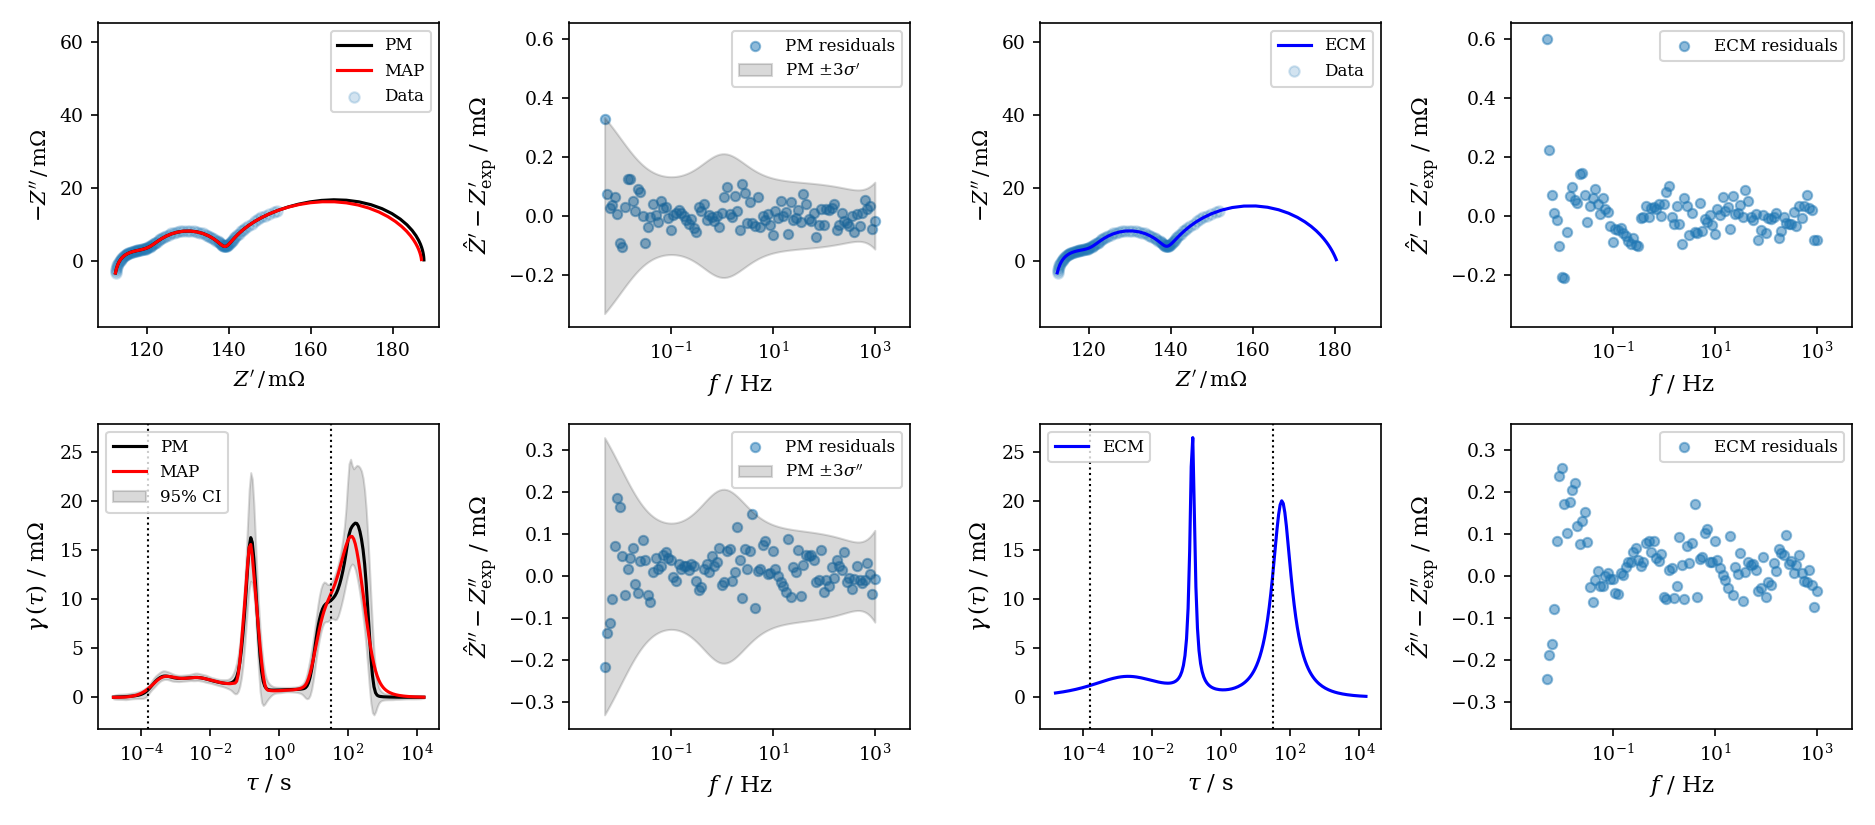

../bayes-drt\drt.py:1095: RuntimeWarning: overflow encountered in exp
  return phi(y,epsilon)/(1+np.exp(2*(y+np.log(w_n*t_m))))
../bayes-drt\drt.py:1208: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  A_main[n,:] = [quad(func,limits[0],limits[1],args=(w_n,t_m,epsilon),epsabs=1e-4)[0] for t_m in tau]


PM RSS: 6.48e-07


../bayes-drt\drt.py:1095: RuntimeWarning: overflow encountered in exp
  return phi(y,epsilon)/(1+np.exp(2*(y+np.log(w_n*t_m))))
../bayes-drt\drt.py:1208: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  A_main[n,:] = [quad(func,limits[0],limits[1],args=(w_n,t_m,epsilon),epsabs=1e-4)[0] for t_m in tau]


MAP RSS: 7.44e-07
ECM RSS: 1.5e-06


In [177]:
Z_file = '../data/experimental/DRTtools_LIB_data.txt'
Zecm_file = '../data/experimental/Z_ECM_LIB.csv'
g_file = '../data/experimental/gamma_LIB_ECM.csv'
suffix = '_LIB_data'
fig,axes = plot_exp_results(Z_file,Zecm_file,g_file,suffix,extrap_freq=np.logspace(3,-5,81))

fig.savefig(os.path.join(plotdir,'LIB_results.png'),dpi=400,transparent=True)

In [171]:
Z_file = '../data/experimental/PDAC_COM3_02109_Contact10_2065C_500C.txt'
Zdf = gt.read_eis_zdata(Z_file)
Zdf['Freq'].values

array([1.000020e+06, 8.577539e+05, 7.356445e+05, 6.309961e+05,
       5.412305e+05, 4.642383e+05, 3.981445e+05, 3.415430e+05,
       2.929102e+05, 2.511914e+05, 2.154492e+05, 1.848633e+05,
       1.584961e+05, 1.359961e+05, 1.166602e+05, 1.000195e+05,
       8.583984e+04, 7.365234e+04, 6.310547e+04, 5.419922e+04,
       4.646484e+04, 3.990234e+04, 3.416016e+04, 2.935547e+04,
       2.513672e+04, 2.162109e+04, 1.857422e+04, 1.587891e+04,
       1.365234e+04, 1.166016e+04, 1.001953e+04, 8.613281e+03,
       7.349537e+03, 6.307871e+03, 5.381944e+03, 4.630335e+03,
       3.993056e+03, 3.414352e+03, 2.915396e+03, 2.519531e+03,
       2.141204e+03, 1.841518e+03, 1.580669e+03, 1.362645e+03,
       1.171875e+03, 1.000702e+03, 8.574695e+02, 7.341868e+02,
       6.288110e+02, 5.427632e+02, 4.635989e+02, 4.001524e+02,
       3.417969e+02, 2.929687e+02, 2.520161e+02, 2.150229e+02,
       1.845472e+02, 1.580056e+02, 1.365291e+02, 1.162190e+02,
       9.973404e+01, 8.600917e+01, 7.381890e+01, 6.2919

<IPython.core.display.Javascript object>


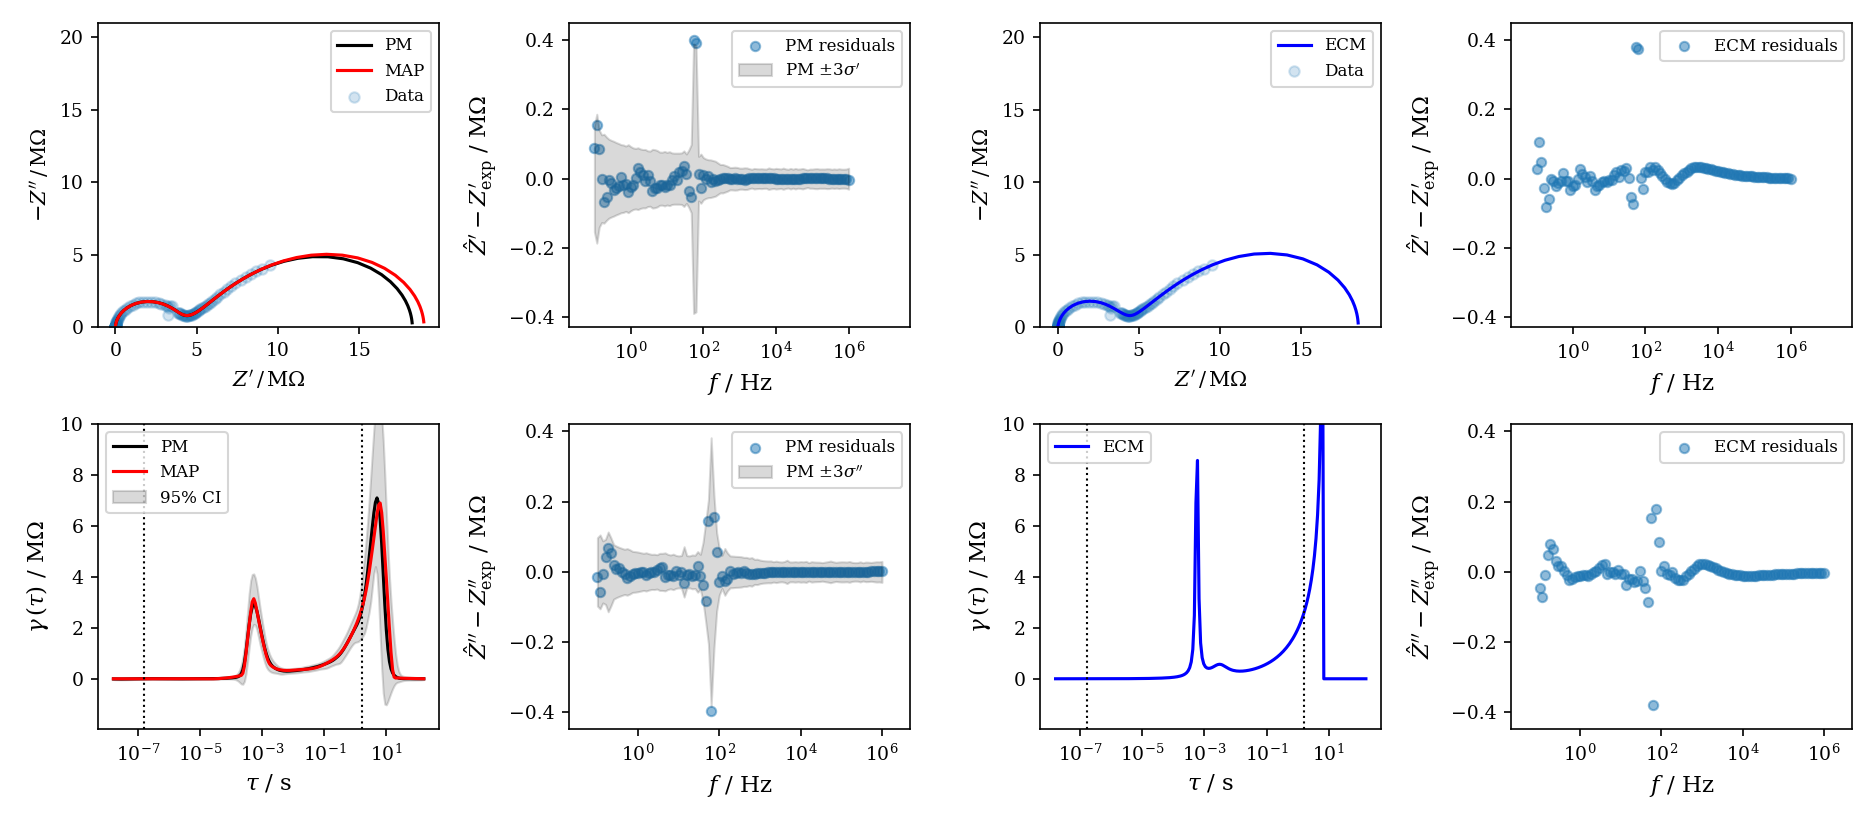

../bayes-drt\drt.py:1095: RuntimeWarning: overflow encountered in exp
  return phi(y,epsilon)/(1+np.exp(2*(y+np.log(w_n*t_m))))


PM RSS: 6.1e+11


../bayes-drt\drt.py:1095: RuntimeWarning: overflow encountered in exp
  return phi(y,epsilon)/(1+np.exp(2*(y+np.log(w_n*t_m))))


MAP RSS: 5.84e+11
ECM RSS: 6e+11


In [176]:
Z_file = '../data/experimental/PDAC_COM3_02109_Contact10_2065C_500C.txt'
Zecm_file = '../data/experimental/Z_ECM-ger_PDAC.csv'
g_file = '../data/experimental/gamma_PDAC_ECM-ger.csv'
suffix = '_PDAC_outliers'
fig,axes = plot_exp_results(Z_file,Zecm_file,g_file,suffix,extrap_freq=np.logspace(6,-3,91))

axes[1,0].set_ylim(axes[1,0].get_ylim()[0],10)

axes[0,3].legend(loc='upper right')
axes[0,3].set_xlim(axes[0,3].get_xlim()[0],5e7)

fig.savefig(os.path.join(plotdir,'TCO_results.png'),dpi=400,transparent=True)

<IPython.core.display.Javascript object>


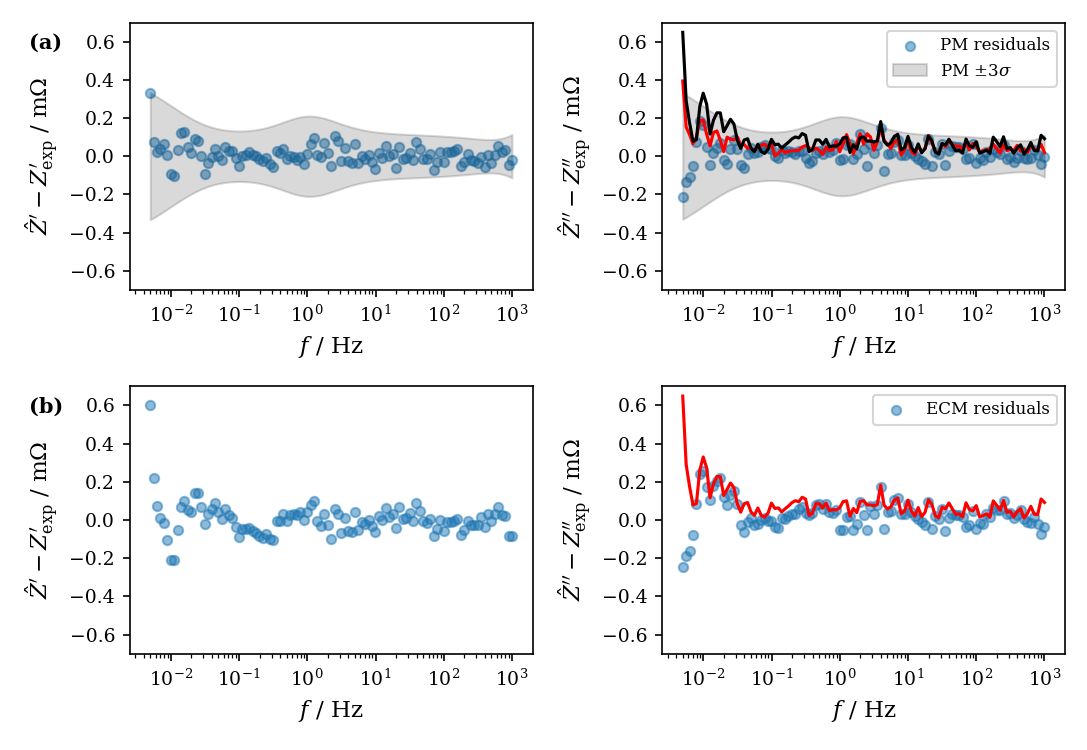

PM 6.477367075285517e-07
ECM 1.5046550744275188e-06


In [88]:
# plot residuals for full dataset for ECM, PM, and GP
fig,axes = plt.subplots(2,2,figsize=(7.25,5))

Z_file = '../data/experimental/DRTtools_LIB_data.txt'
suffix = '_LIB_data'
Zdf = pd.read_csv(Z_file,sep='\t',header=None)
Zdf = pd.DataFrame(Zdf.values,columns=['Freq','Zreal','Zimag'])
freq = Zdf['Freq'].values

# scatter formatting
scat_kw = {'s':20,'alpha':0.5}

# PM and GP
for axrow,model_name in zip(axes,['PM']):
    Zres = pd.read_csv(os.path.join(model_info[model_name]['path'],f'Zout{suffix}.csv'))
    if model_name=='PM':
        # parse complex numbers
        real_cols = ['freq','Zreal','Zimag']
        for col in real_cols:
            Zres[col] = Zres[col].str.replace('i','j').apply(lambda x: np.complex(x))
            Zres[col] = np.real(Zres[col])
        imag_cols = ['Zlo','Zhi']
        for col in imag_cols:
            Zres[col] = Zres[col].str.replace('i','j').apply(lambda x: np.complex(x))
            
    axrow[0].scatter(freq,(Zres['Zreal']-Zdf['Zreal'])*1000,label=fr'{model_name} residuals',**scat_kw)
    axrow[1].scatter(freq,(Zres['Zimag']-Zdf['Zimag'])*1000,label=fr'{model_name} residuals',**scat_kw)
    
    rss = np.sum((Zres['Zreal']-Zdf['Zreal'])**2) + np.sum((Zres['Zimag']-Zdf['Zimag'])**2)
    print(model_name,rss)
    
    axrow[1].plot(freq,np.sqrt((Zres['Zreal']-Zdf['Zreal'])**2 + (Zres['Zimag']-Zdf['Zimag'])**2)*1e3,c='r')
    
    # GP error scale
#     if model_name=='GP':
#         axrow[1].fill_between(freq,-3e3*Zres['sigma_im'],3e3*Zres['sigma_im'],alpha=0.15,color='g',lw=1,
#                               label='GP $\pm 3 \sigma$')

# ECM residuals
Zecm_file = '../data/experimental/Z_ECM_LIB.csv'
ecm_df = pd.read_csv(Zecm_file)
axes[1,0].scatter(freq,(ecm_df['Zreal']-Zdf['Zreal'])*1000,label=r'ECM residuals',**scat_kw)
axes[1,1].scatter(freq,(ecm_df['Zimag']-Zdf['Zimag'])*1000,label=r'ECM residuals',**scat_kw)

rss = np.sum((ecm_df['Zreal']-Zdf['Zreal'])**2) + np.sum((ecm_df['Zimag']-Zdf['Zimag'])**2)
print('ECM',rss)
axes[1,1].plot(freq,np.sqrt((ecm_df['Zreal']-Zdf['Zreal'])**2 + (ecm_df['Zimag']-Zdf['Zimag'])**2)*1e3,c='r')
axes[0,1].plot(freq,np.sqrt((ecm_df['Zreal']-Zdf['Zreal'])**2 + (ecm_df['Zimag']-Zdf['Zimag'])**2)*1e3,c='k')

# PM error scale
dr_mcmc = load_pickle(os.path.join(model_info['PM']['path'],f'obj{suffix}.pkl'))
sigma_re,sigma_im = dr_mcmc.predict_err_scale(Zdf['Freq'].values)
axes[0,0].fill_between(freq,-3e3*sigma_re,3e3*sigma_re,alpha=0.15,color='k',lw=1,label='3$\sigma^\prime$')
axes[0,1].fill_between(freq,-3e3*sigma_im,3e3*sigma_im,alpha=0.15,color='k',lw=1,label='PM $\pm 3 \sigma$')
        
# formatting
for ax in axes.ravel():
    ax.set_xscale('log')
    ax.set_ylim(-7e-1,7e-1)
    ax.set_xlim(np.min(freq)/2,np.max(freq)*2)
    ax.set_xlabel('$f$ / Hz')
    
for n,ax in enumerate(axes[:,0]):
    ax.set_ylabel('$\hat{Z}^\prime - Z^\prime_{\mathrm{exp}}$ / m$\Omega$')
    let = chr(n+97)
    ax.text(-0.25,0.9,f'({let})',transform=ax.transAxes,fontweight='bold')   
    h,l = ax.get_legend_handles_labels()
#     ax.legend(handles=h[::-1],labels=l[::-1],loc='upper right')
    
for ax in axes[:,1]:
    ax.set_ylabel('$\hat{Z}^{\prime\prime} - Z^{\prime\prime}_{\mathrm{exp}}$ / m$\Omega$')
    h,l = ax.get_legend_handles_labels()
    ax.legend(loc='upper right')
    
fig.tight_layout()
# fig.savefig(os.path.join(plotdir,'Residuals_LIB.jpg'),dpi=500)
# fig.savefig(os.path.join(latexdir,'Residuals_LIB.pdf'),dpi=500)

In [256]:
g_true['tau']

0        0.006738
1        0.007103
2        0.007488
3        0.007894
4        0.008321
          ...    
195    198.134229
196    208.869268
197    220.185938
198    232.115753
199    244.691932
Name: tau, Length: 200, dtype: float64

<IPython.core.display.Javascript object>


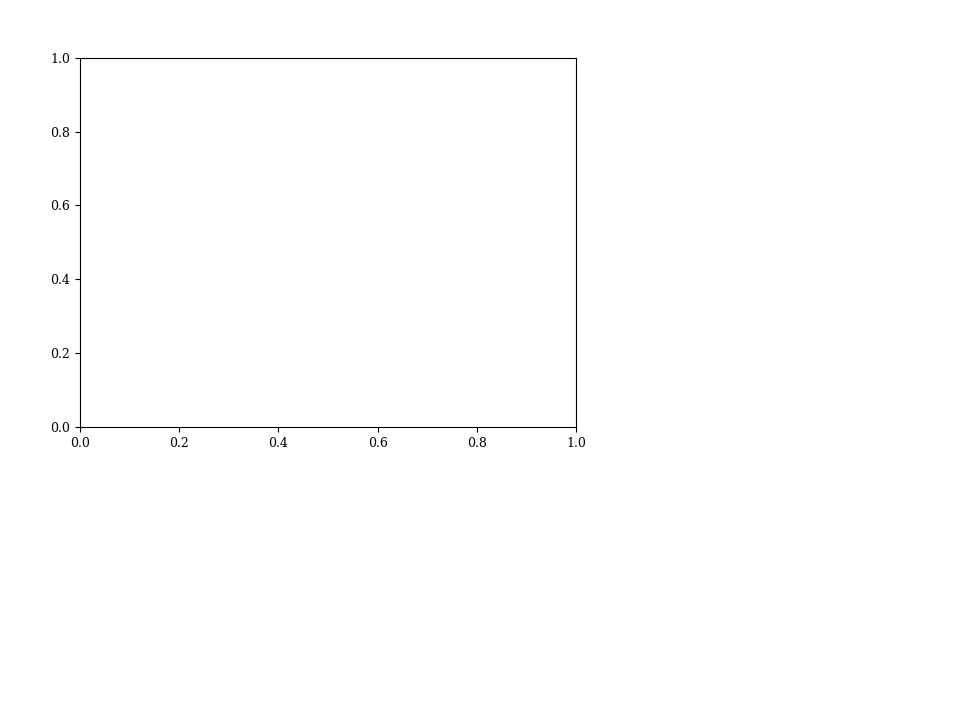

ValueError: x and y must have same first dimension, but have shapes (199,) and (200,)

In [254]:
fig,ax=plt.subplots()

